In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier
import collections
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("./****.txt",sep = "\t")
dataset.head()

,SD1,SD2,SD3,SD4,SD5,SD6,SD7,SD8,SD9,SD10,...,PO78,PO79,PO80,PO81,PO82,PO83,PO84,PO85,CLASS,STATUS
0,33,1,3,2,8,0,5,1,3,7,...,0,0,1,0,0,0,0,0,No,Learning
1,37,1,2,2,8,1,4,1,4,6,...,0,0,1,0,0,0,0,0,No,Learning
2,37,1,2,2,8,0,4,2,4,3,...,0,0,1,0,0,0,0,0,No,Learning
3,9,1,3,3,3,2,3,2,4,5,...,0,0,1,0,0,0,0,0,No,Learning
4,40,1,4,2,10,1,4,1,4,7,...,0,0,1,0,0,0,0,0,No,Learning


In [3]:
train = dataset.loc[dataset["STATUS"] == "Learning", :].drop(columns='STATUS', axis = 1)
test = dataset.loc[dataset["STATUS"] == "Test"].drop(columns='STATUS', axis = 1)
dataset = dataset.drop(columns='STATUS', axis = 1)
dataset.shape

(9822, 86)

On va transformer la variable Class en une variable numérique avec Label Encoder

In [4]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(dataset["CLASS"])
dataset["CLASS"] = encoder.transform(dataset["CLASS"])

On va maintenant étudier la corrélation entre les variables et garder les variables importantes

In [5]:
#fortement corrélé a partir de 0.8
seuil = 0.8
cor = dataset.corr().abs()
cor.head()

,SD1,SD2,SD3,SD4,SD5,SD6,SD7,SD8,SD9,SD10,...,PO77,PO78,PO79,PO80,PO81,PO82,PO83,PO84,PO85,CLASS
SD1,1.000000,0.040328,0.006594,0.014428,0.992712,0.203087,0.092478,0.029237,0.016571,0.050488,...,0.021546,0.011611,0.000815,0.000469,0.005283,0.012901,0.025533,0.016336,0.043749,0.060742
SD2,0.040328,1.000000,0.004315,0.052448,0.048317,0.004304,0.031296,0.020160,0.018018,0.006801,...,0.003267,0.007011,0.012374,0.001343,0.007991,0.001384,0.012526,0.031936,0.005851,0.002836
SD3,0.006594,0.004315,1.000000,0.339942,0.029737,0.009383,0.053455,0.113296,0.010404,0.531272,...,0.002878,0.017853,0.019305,0.004668,0.003888,0.013174,0.018487,0.010928,0.030856,0.046224
SD4,0.014428,0.052448,0.339942,1.000000,0.009698,0.038454,0.091775,0.058412,0.114922,0.058155,...,0.020911,0.001029,0.001511,0.017606,0.004048,0.008401,0.018824,0.009157,0.012377,0.004227
SD5,0.992712,0.048317,0.029737,0.009698,1.000000,0.208057,0.100622,0.038340,0.018710,0.012349,...,0.022526,0.009087,0.002128,0.000024,0.003526,0.015422,0.027067,0.015549,0.041213,0.059306


In [6]:
cor_up = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool))
cor_up.head()

,SD1,SD2,SD3,SD4,SD5,SD6,SD7,SD8,SD9,SD10,...,PO77,PO78,PO79,PO80,PO81,PO82,PO83,PO84,PO85,CLASS
SD1,NaN,0.040328,0.006594,0.014428,0.992712,0.203087,0.092478,0.029237,0.016571,0.050488,...,0.021546,0.011611,0.000815,0.000469,0.005283,0.012901,0.025533,0.016336,0.043749,0.060742
SD2,NaN,NaN,0.004315,0.052448,0.048317,0.004304,0.031296,0.020160,0.018018,0.006801,...,0.003267,0.007011,0.012374,0.001343,0.007991,0.001384,0.012526,0.031936,0.005851,0.002836
SD3,NaN,NaN,NaN,0.339942,0.029737,0.009383,0.053455,0.113296,0.010404,0.531272,...,0.002878,0.017853,0.019305,0.004668,0.003888,0.013174,0.018487,0.010928,0.030856,0.046224
SD4,NaN,NaN,NaN,NaN,0.009698,0.038454,0.091775,0.058412,0.114922,0.058155,...,0.020911,0.001029,0.001511,0.017606,0.004048,0.008401,0.018824,0.009157,0.012377,0.004227
SD5,NaN,NaN,NaN,NaN,NaN,0.208057,0.100622,0.038340,0.018710,0.012349,...,0.022526,0.009087,0.002128,0.000024,0.003526,0.015422,0.027067,0.015549,0.041213,0.059306


In [7]:
c = cor_up.unstack()
pair = c[c > seuil]

In [8]:
feat_class_cor = cor['CLASS'].sort_values(ascending = False)
feat_class_cor.head()

CLASS    1.000000
PO47     0.137053
PO68     0.126768
SD43     0.099018
PO44     0.098757
Name: CLASS, dtype: float64

In [9]:
def feat_drop(feats):
    """
    la fonction permet de supprimer la variable la moins corrélée avec la variable cible parmi deux variables corrélées entre elles
    """
    liste = []
    for i in range(len(feats)):
        a = feats.index[i]
        if a in pair:
            corr_a_class = feats[i]
            corr_a_var = pair[a]
            if feats[pair[a].index[0]] > corr_a_class:
                liste.append(a)
            else:
                liste.append(pair[a].index[0])

    return liste

In [10]:
feat_d = feat_drop(feat_class_cor)

In [11]:
dataset = dataset.drop(columns=feat_d)


In [12]:
test = test.drop(columns=feat_d)

In [13]:
dataset.shape

(9822, 61)

On va maintenant utiliser RandomForest pour déterminer les variables qui n'ont aucun impact sur la variable cible, et les éliminer 

In [14]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
clf_RF = RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=True )
clf_RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
feature_importance = pd.DataFrame({'Feature':list(X_train.columns), 'Importance':clf_RF.feature_importances_*100})

In [16]:
feature_importance.head(20)

,Feature,Importance
0,SD1,3.586387
1,SD2,0.570678
2,SD3,0.890330
3,SD4,1.294367
4,SD5,2.165298
5,SD6,0.990596
6,SD7,1.884139
7,SD8,1.364925
8,SD9,1.838619
9,SD10,1.502684


In [17]:
zero_importance = feature_importance[feature_importance["Importance"] < 0.1]
zero_importance

,Feature,Importance
45,PO46,0.073465
49,PO50,0.000000
52,PO53,0.007720
55,PO56,0.033625
59,PO60,0.053064
66,PO67,0.038856
70,PO71,0.001583
73,PO74,0.004408
76,PO77,0.021388
80,PO81,0.038739


In [18]:
for i in zero_importance["Feature"]:
    for j in dataset.keys():
        if i ==j:
            dataset = dataset.drop(columns=j)

dataset.shape

(9822, 56)

In [19]:
dataset.keys()

Index(['SD1', 'SD2', 'SD3', 'SD4', 'SD6', 'SD7', 'SD8', 'SD9', 'SD10', 'SD11',
       'SD13', 'SD14', 'SD15', 'SD16', 'SD17', 'SD18', 'SD19', 'SD20', 'SD21',
       'SD22', 'SD23', 'SD24', 'SD25', 'SD26', 'SD27', 'SD28', 'SD29', 'SD30',
       'SD32', 'SD33', 'SD34', 'SD35', 'SD37', 'SD38', 'SD39', 'SD40', 'SD41',
       'SD42', 'SD43', 'PO44', 'PO45', 'PO47', 'PO51', 'PO54', 'PO57', 'PO58',
       'PO59', 'PO64', 'PO69', 'PO70', 'PO73', 'PO76', 'PO82', 'PO83', 'PO84',
       'CLASS'],
      dtype='object')

## Etude Descriptive sociodémographiques des Clients Actuels et Potentiels :

In [42]:
sociodémographiques=dataset.columns[0:39]

In [45]:
Yes=dataset[dataset['CLASS']==1]
No=dataset[dataset['CLASS']==0]

In [46]:
tableModaliteYes={}
listeModalitesYes = []
for c in sociodémographiques : 
    tableModaliteYes[c]=collections.Counter(Yes[c].values)
    
tableModaliteNo={}
listeModalitesNo = []
for c in sociodémographiques : 
    tableModaliteNo[c]=collections.Counter(No[c].values)

In [53]:
def Data_Distribution(c,tableMod,tot):
    keys  = list(tableMod[c].keys())
    values = list(tableMod[c].values())
    d = pd.DataFrame({'modalité': keys,
                  'nombre de modalité': values})
    #d = d.nlargest(columns="nombre de modalité",n=8) 
    plt.figure(figsize=(15,6))
    
    ax = sns.barplot(data=d, x= "modalité", y = "nombre de modalité")
    ax.set(ylabel = 'nombre de modalité')
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '%{:1.2f}'.format(height/(tot)*100),
            ha="center" ) 
    plt.show()

Distribution For Feature :  SD1
Distribution For Yes :


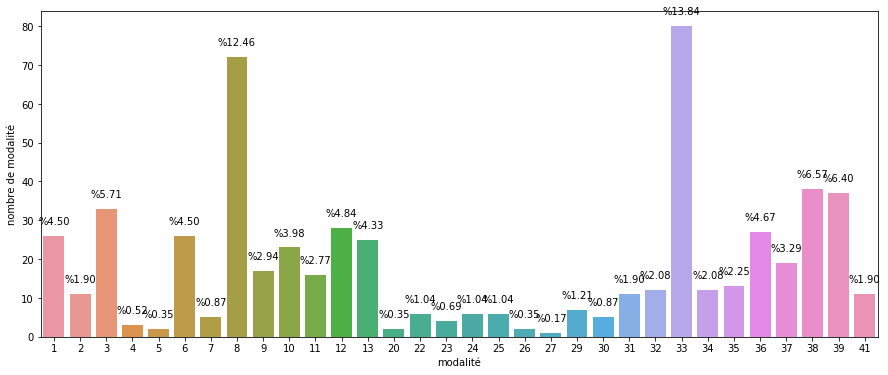

Distribution For No :


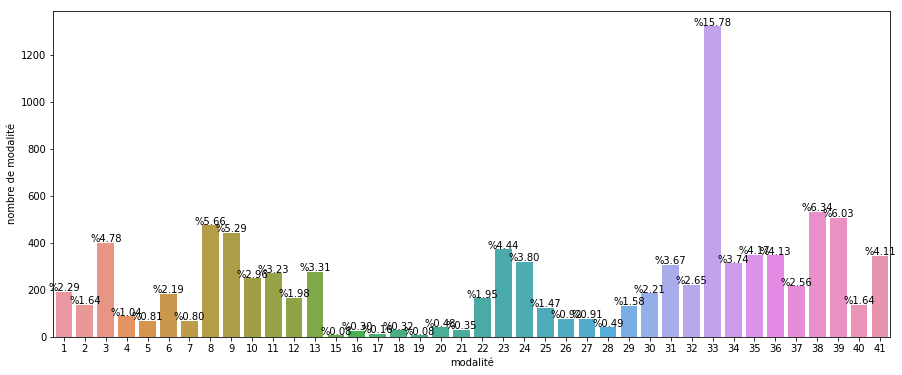

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD2
Distribution For Yes :


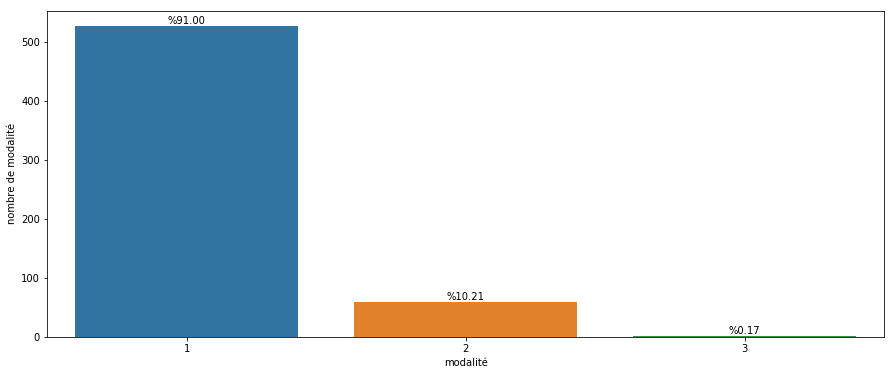

Distribution For No :


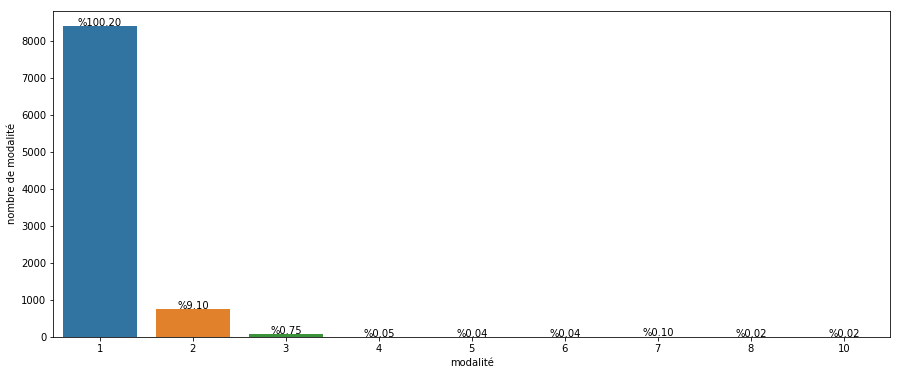

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD3
Distribution For Yes :


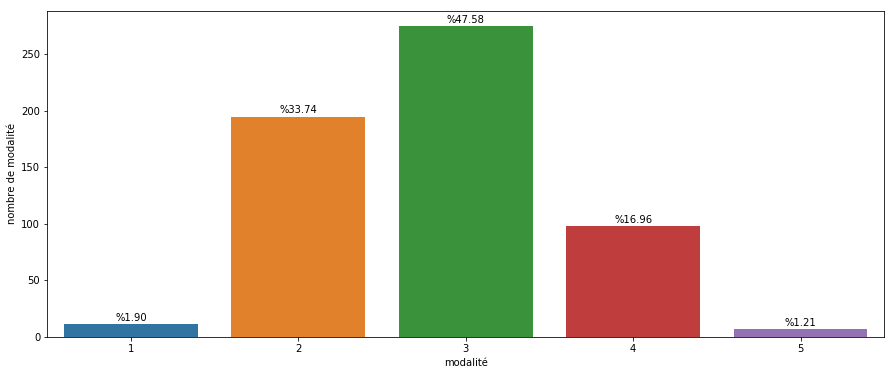

Distribution For No :


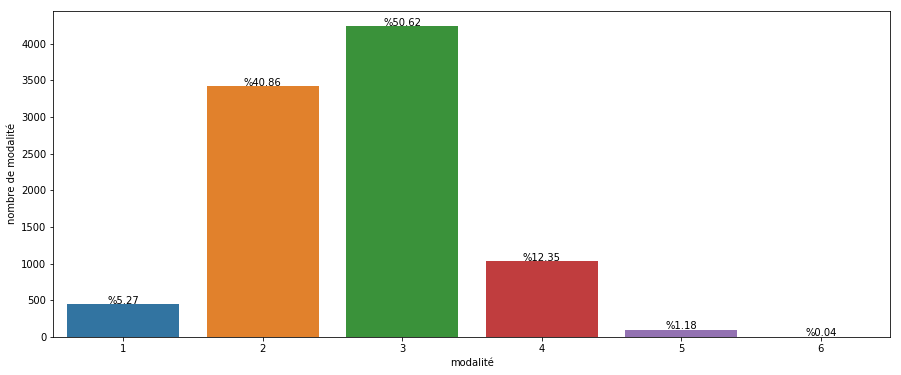

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD4
Distribution For Yes :


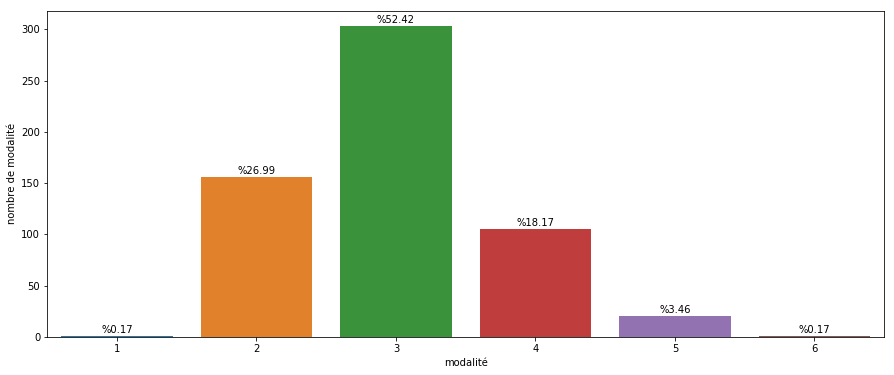

Distribution For No :


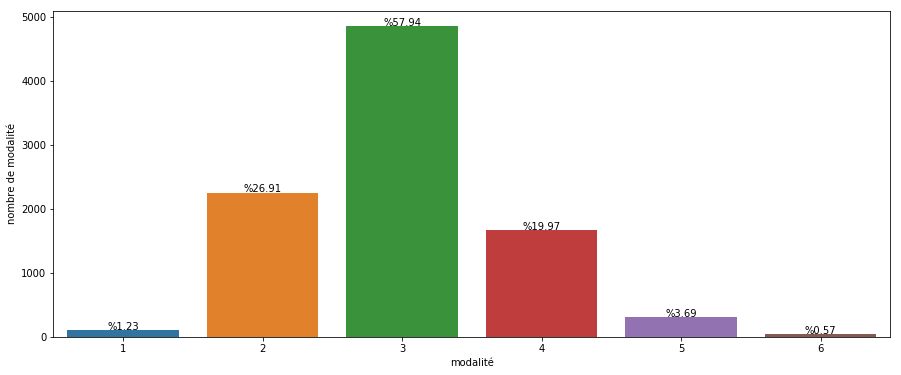

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD6
Distribution For Yes :


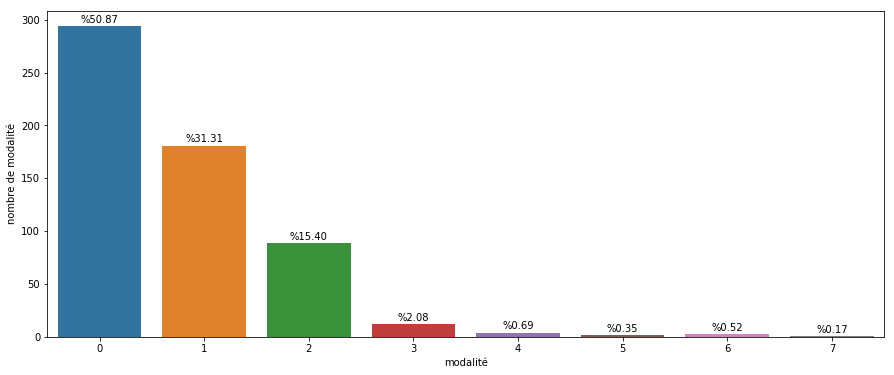

Distribution For No :


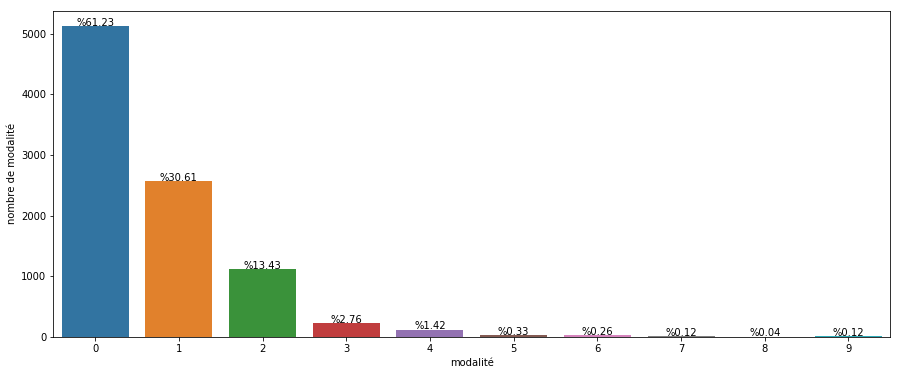

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD7
Distribution For Yes :


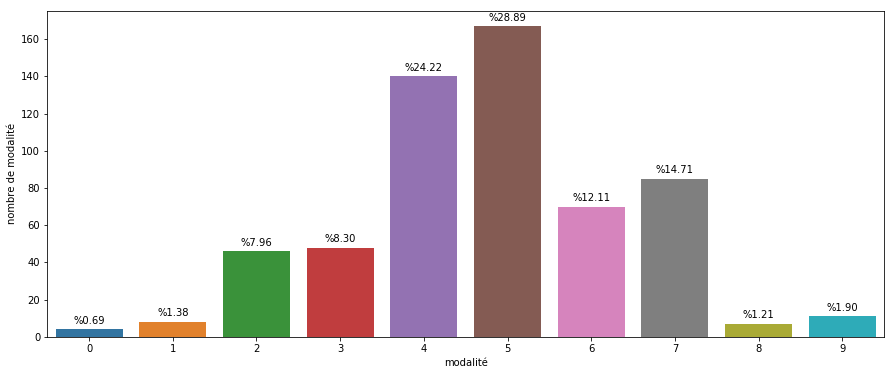

Distribution For No :


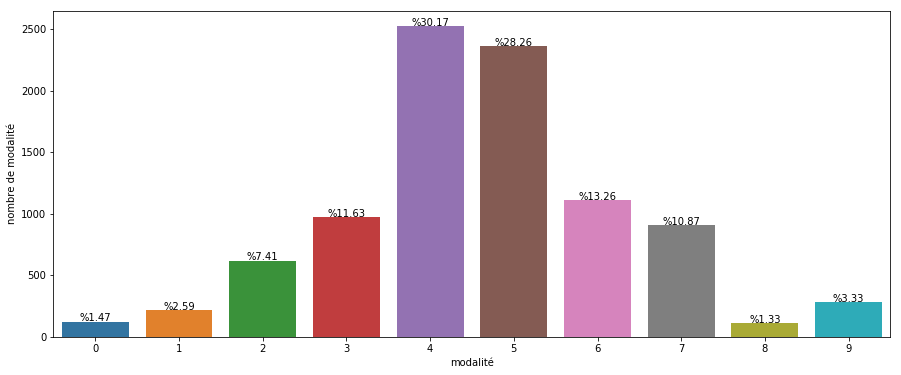

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD8
Distribution For Yes :


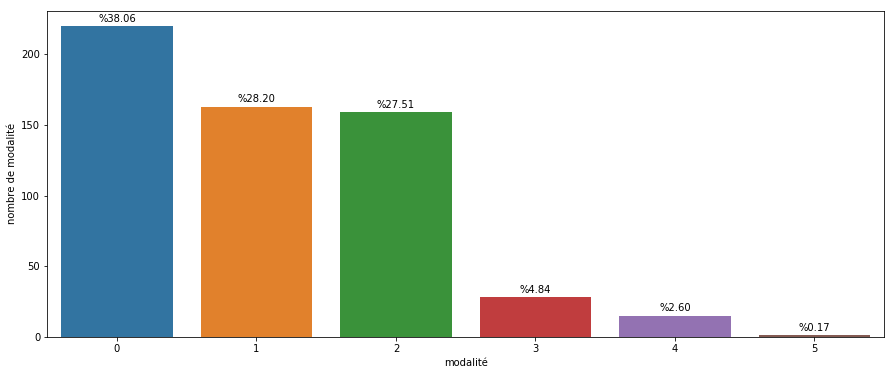

Distribution For No :


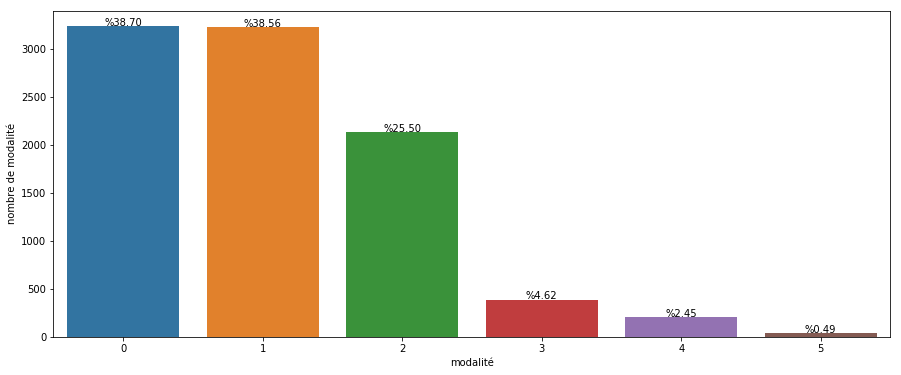

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD9
Distribution For Yes :


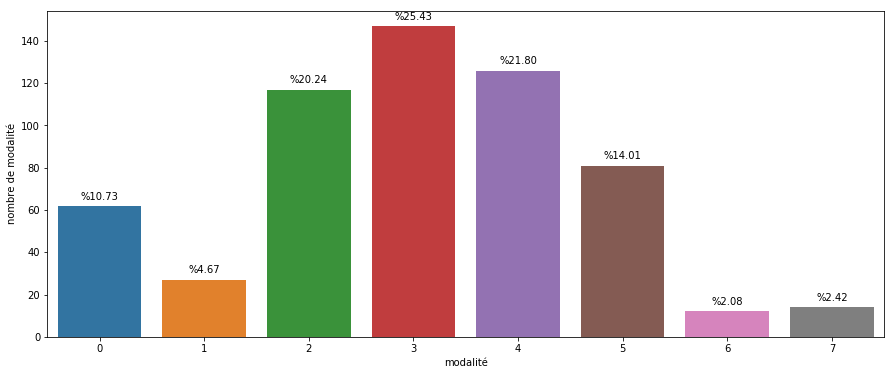

Distribution For No :


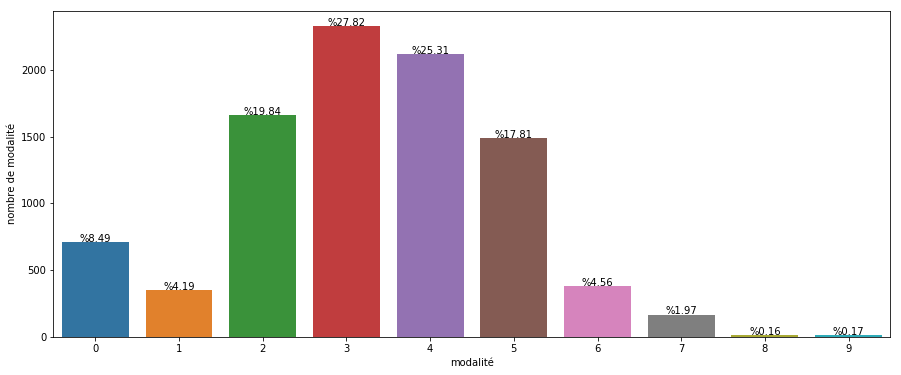

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD10
Distribution For Yes :


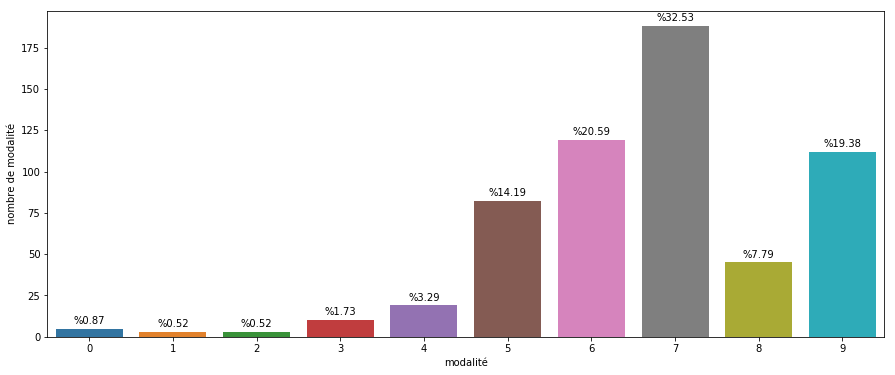

Distribution For No :


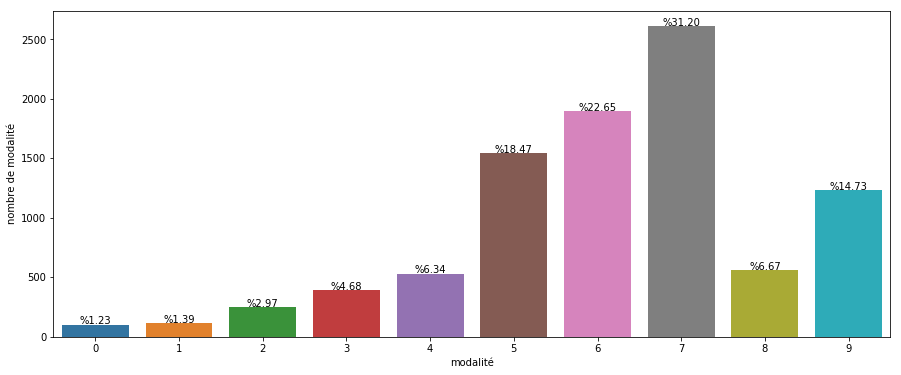

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD11
Distribution For Yes :


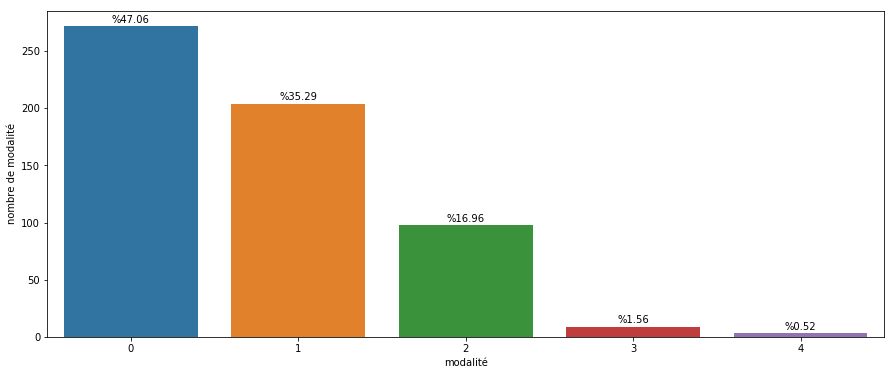

Distribution For No :


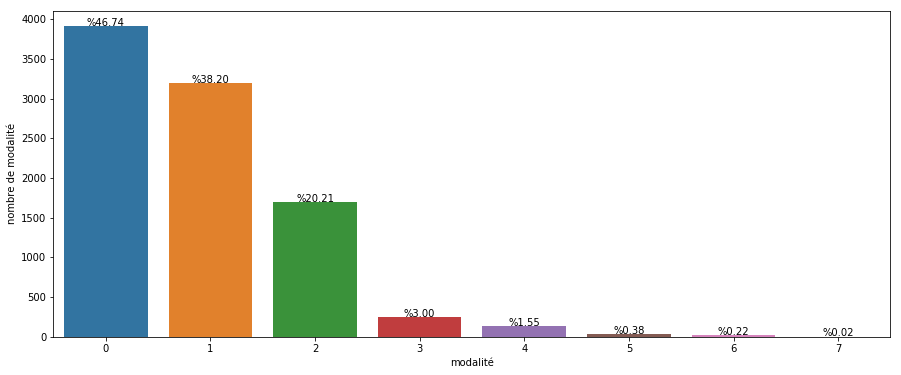

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD13
Distribution For Yes :


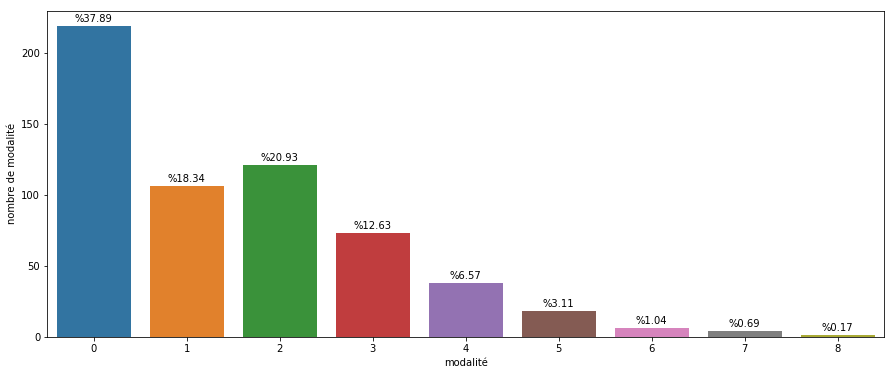

Distribution For No :


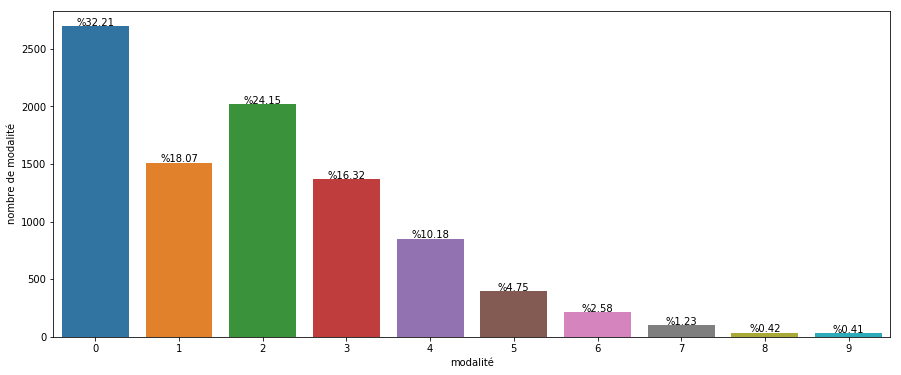

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD14
Distribution For Yes :


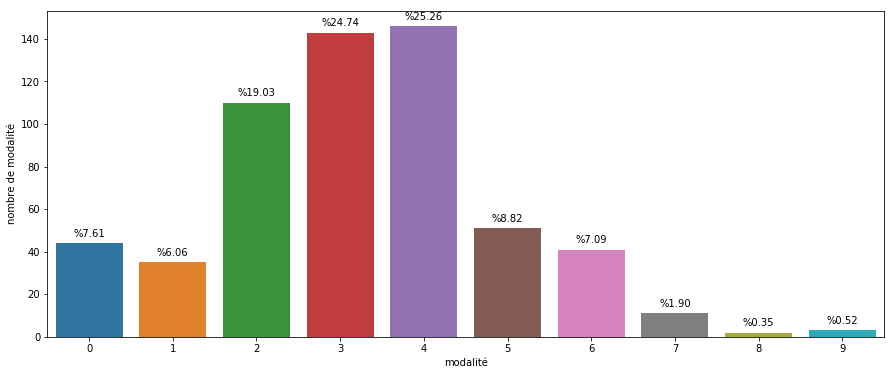

Distribution For No :


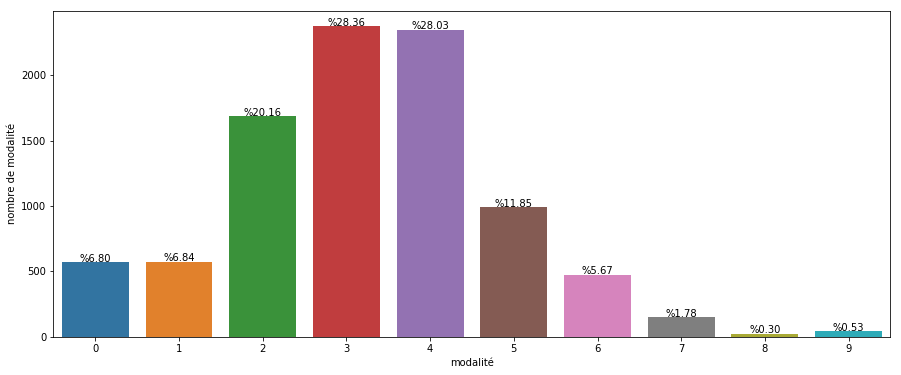

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD15
Distribution For Yes :


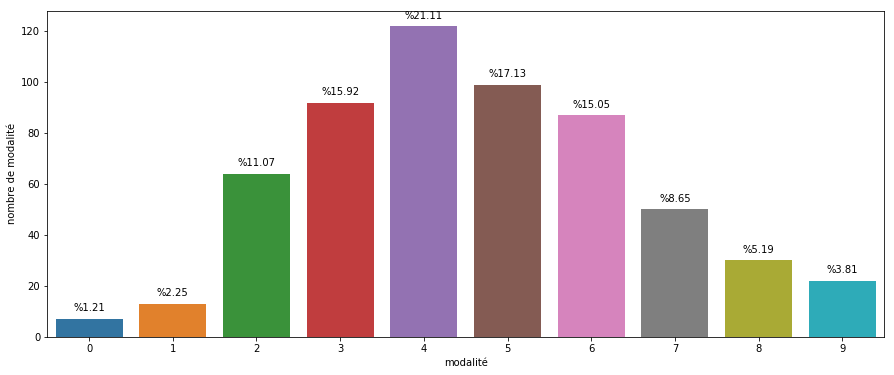

Distribution For No :


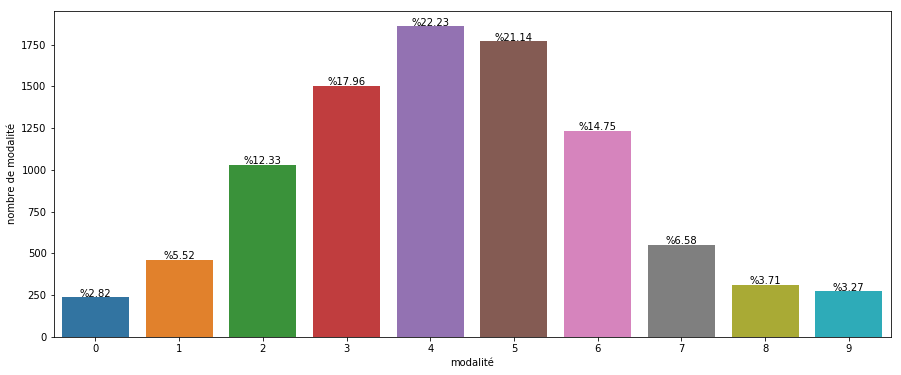

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD16
Distribution For Yes :


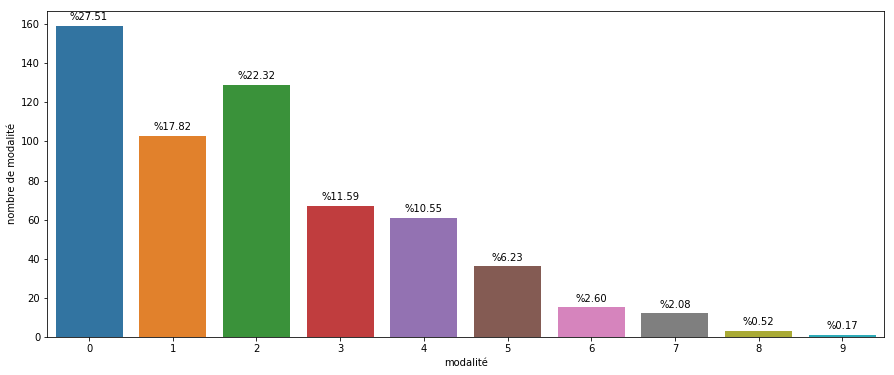

Distribution For No :


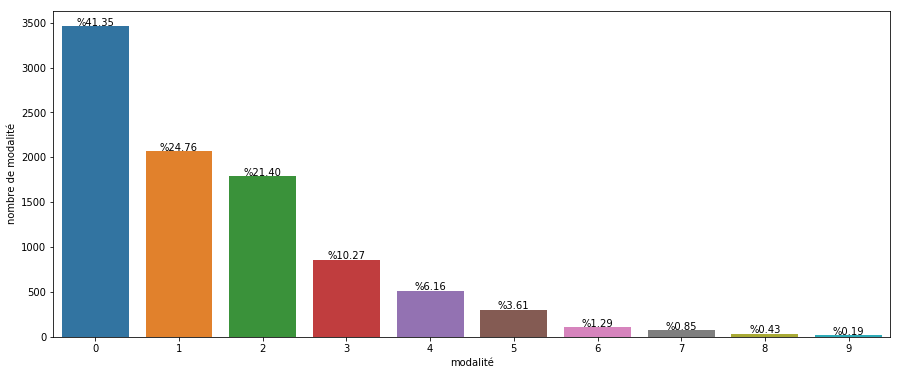

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD17
Distribution For Yes :


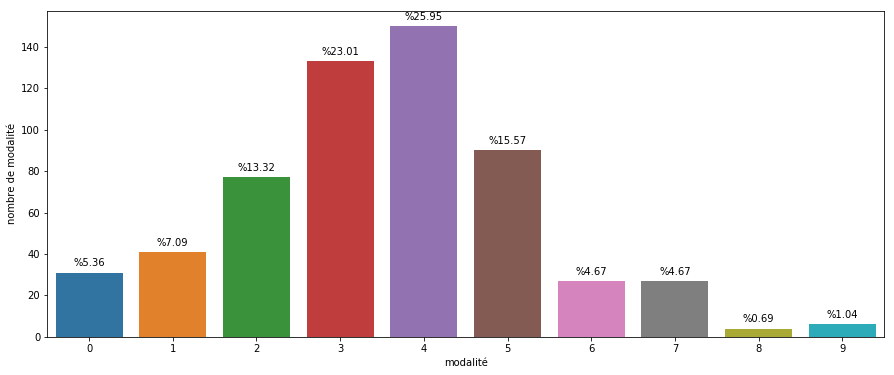

Distribution For No :


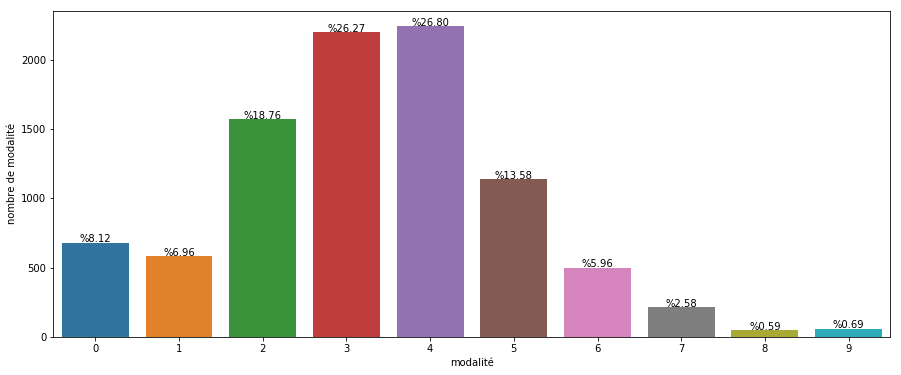

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD18
Distribution For Yes :


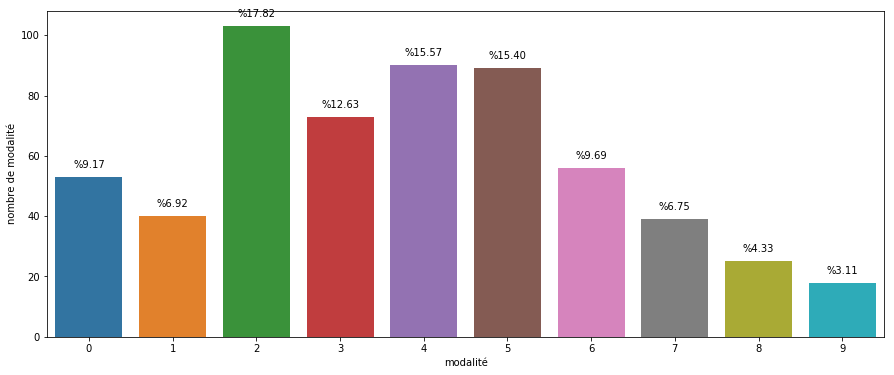

Distribution For No :


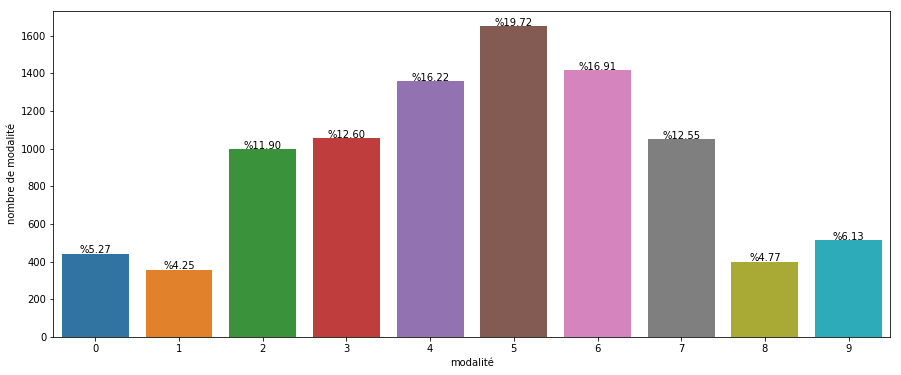

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD19
Distribution For Yes :


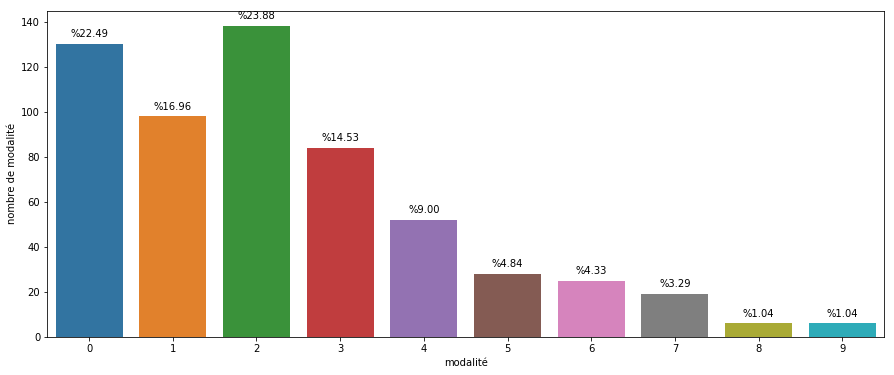

Distribution For No :


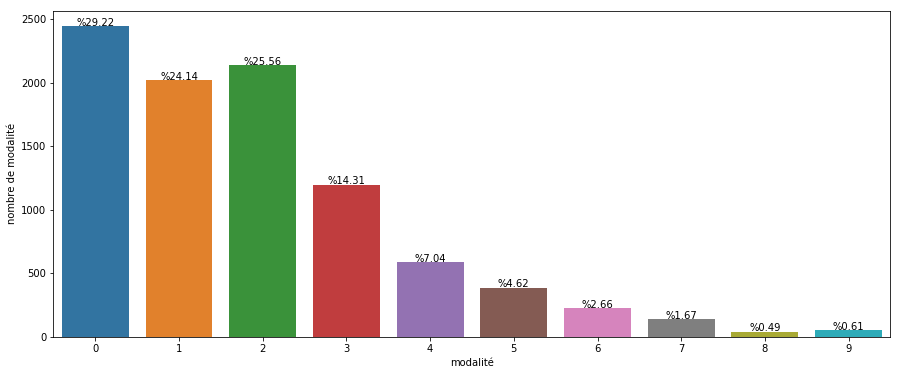

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD20
Distribution For Yes :


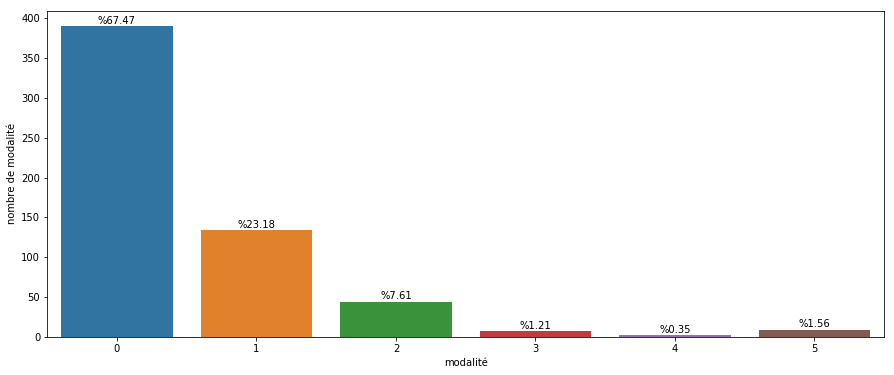

Distribution For No :


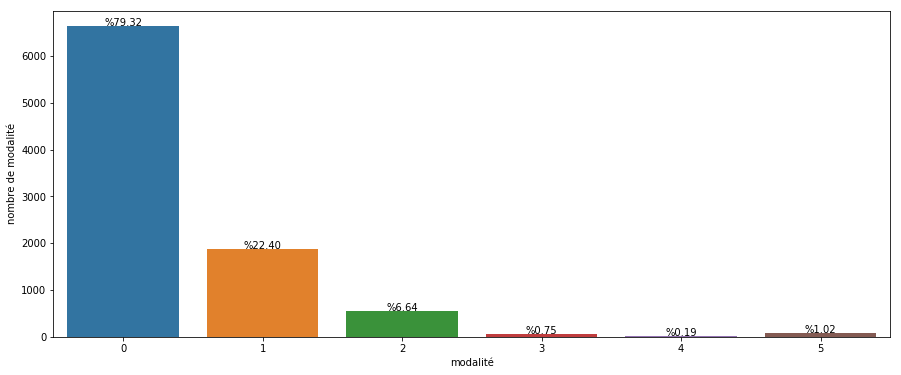

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD21
Distribution For Yes :


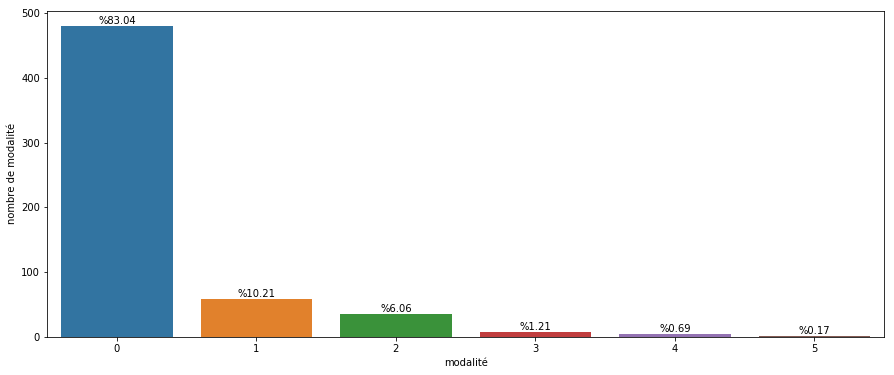

Distribution For No :


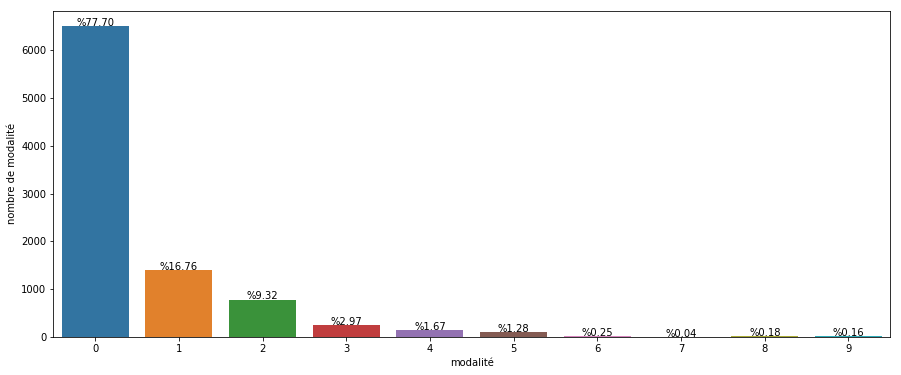

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD22
Distribution For Yes :


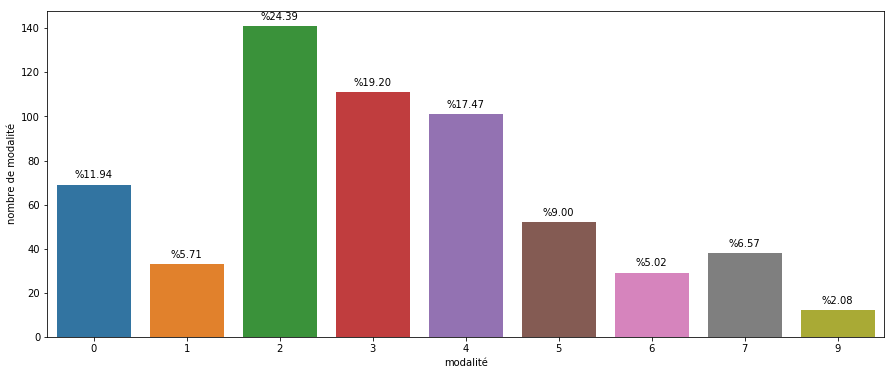

Distribution For No :


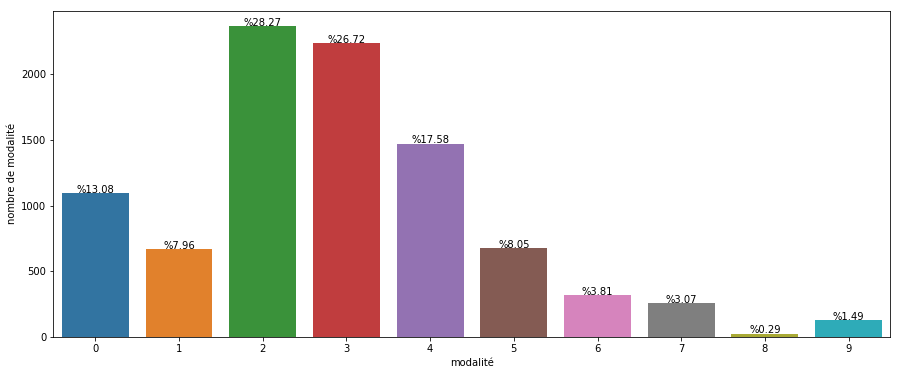

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD23
Distribution For Yes :


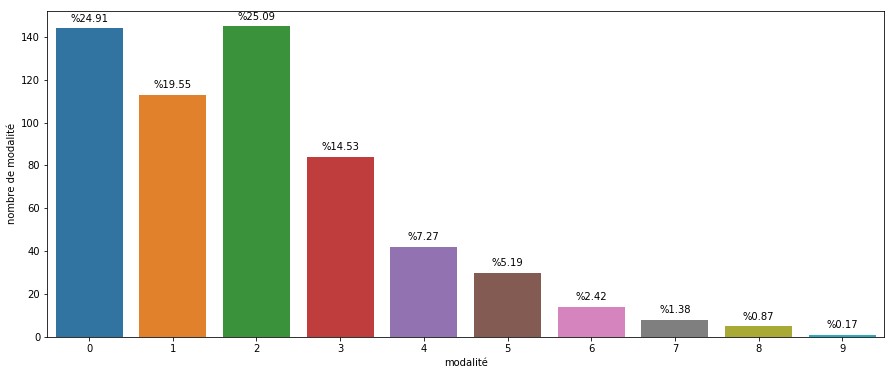

Distribution For No :


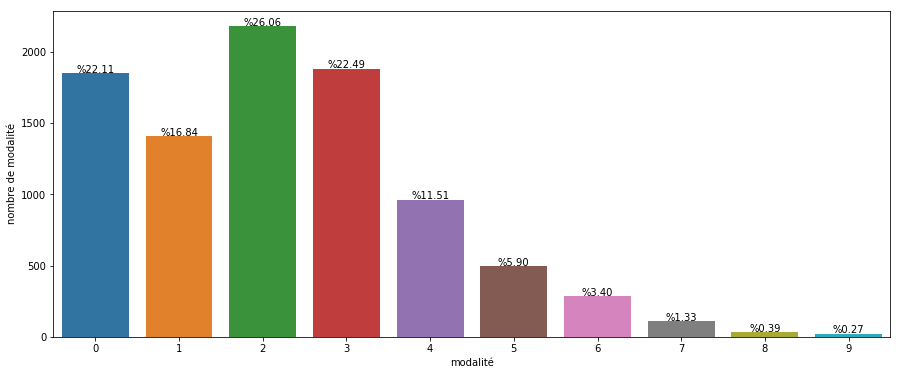

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD24
Distribution For Yes :


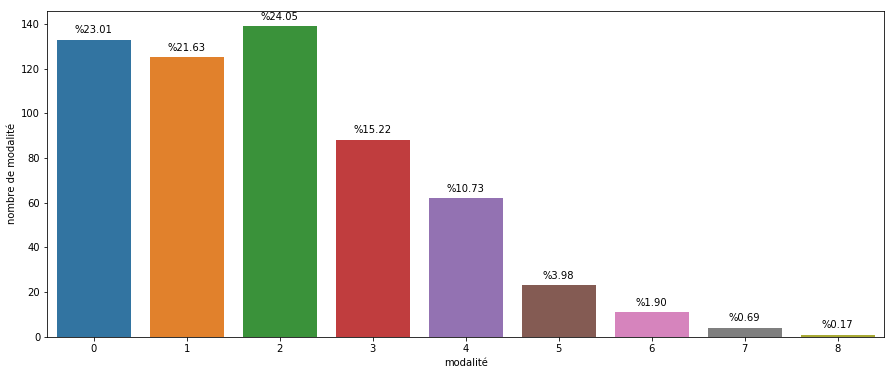

Distribution For No :


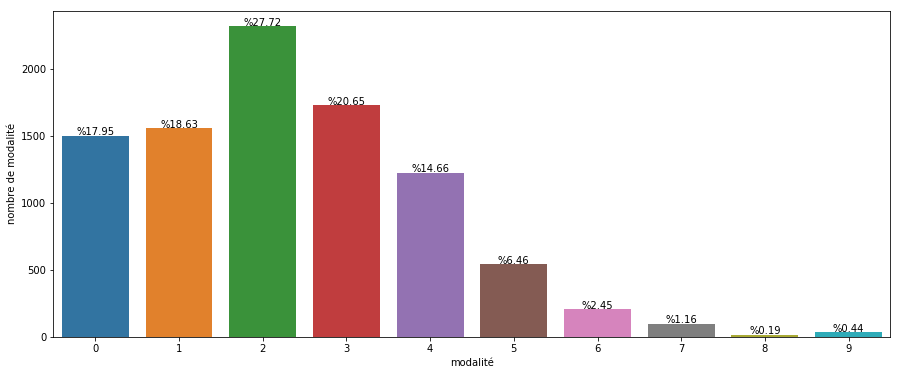

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD25
Distribution For Yes :


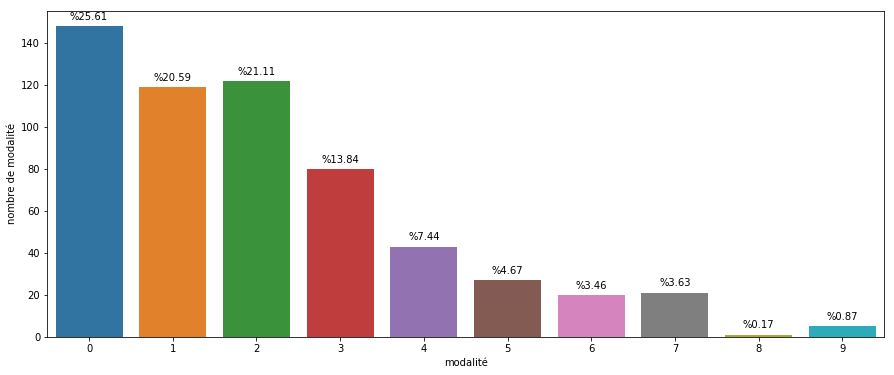

Distribution For No :


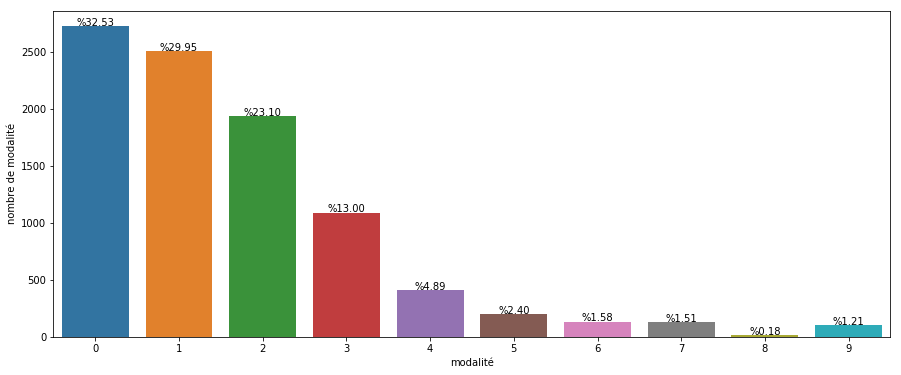

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD26
Distribution For Yes :


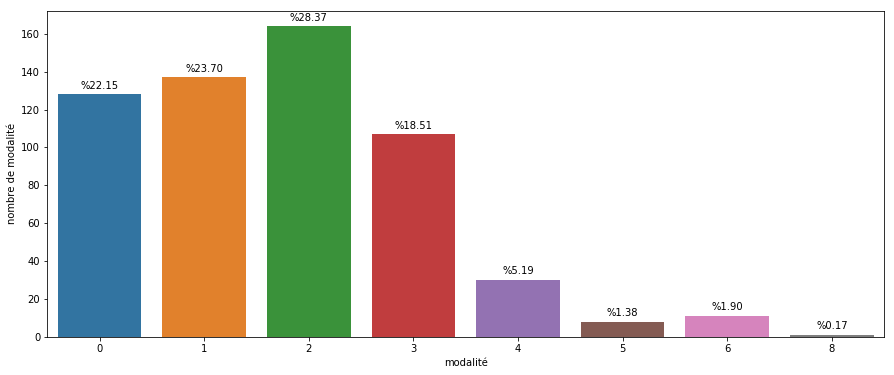

Distribution For No :


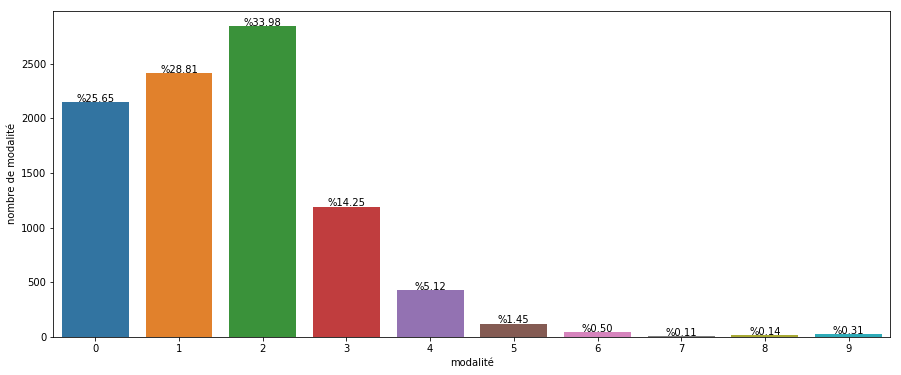

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD27
Distribution For Yes :


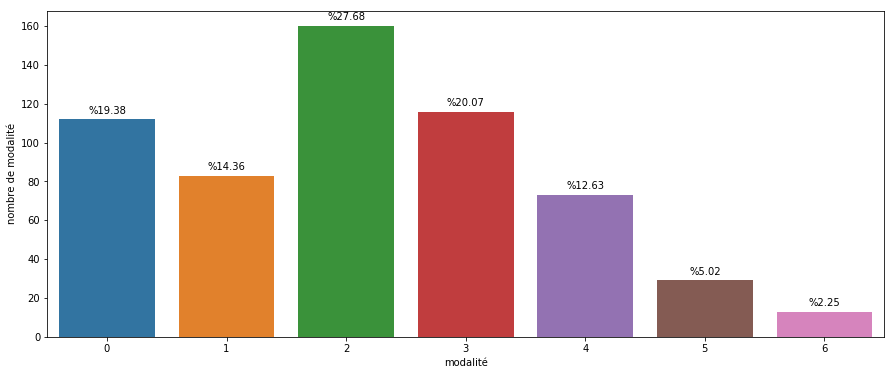

Distribution For No :


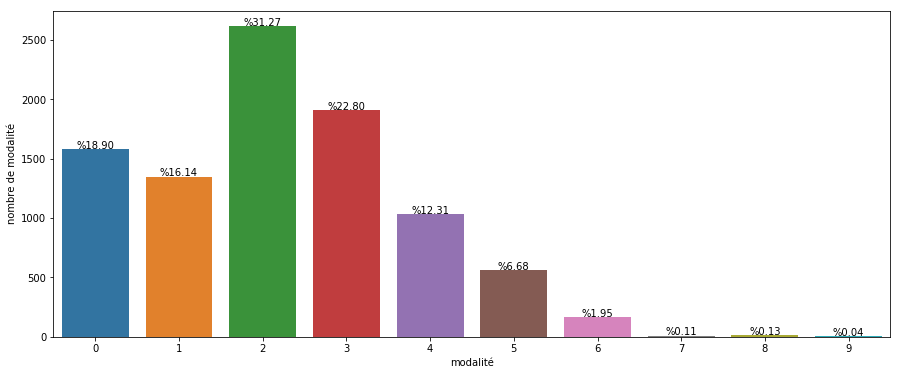

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD28
Distribution For Yes :


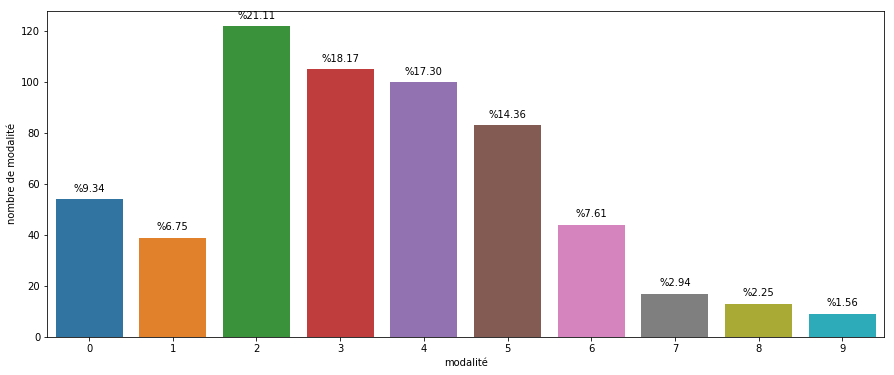

Distribution For No :


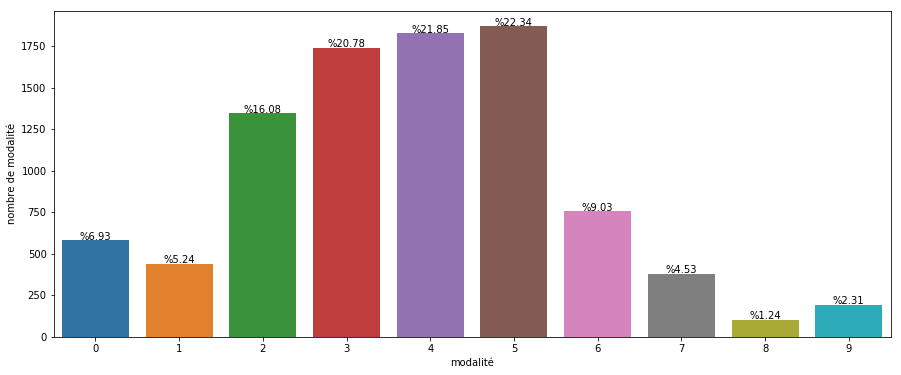

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD29
Distribution For Yes :


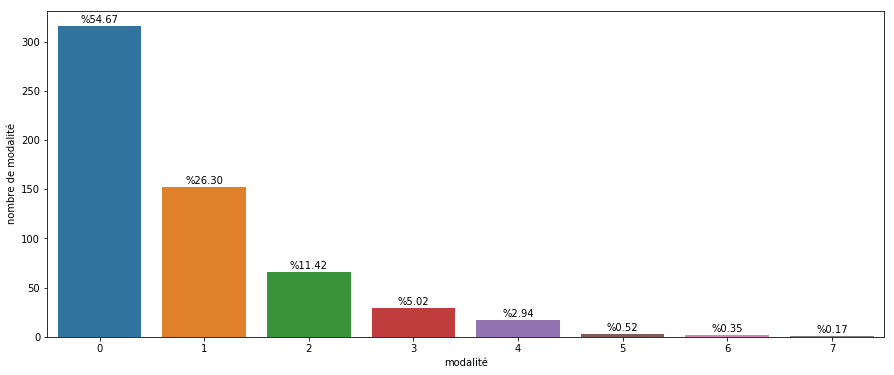

Distribution For No :


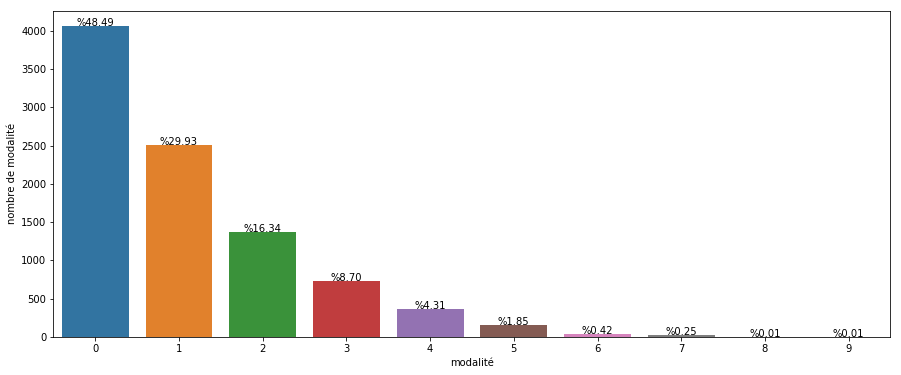

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD30
Distribution For Yes :


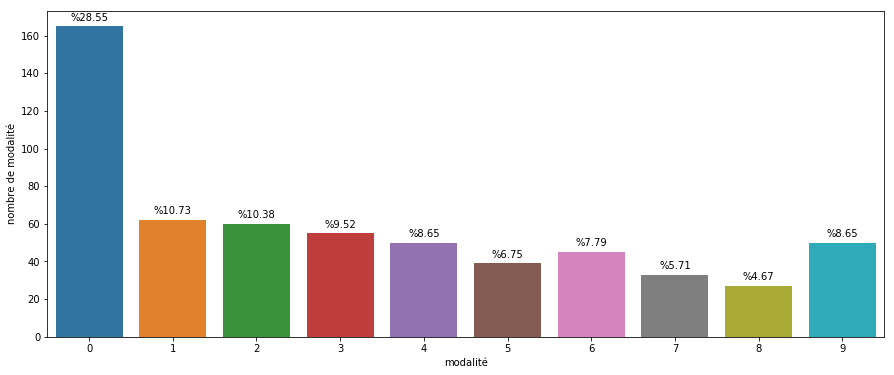

Distribution For No :


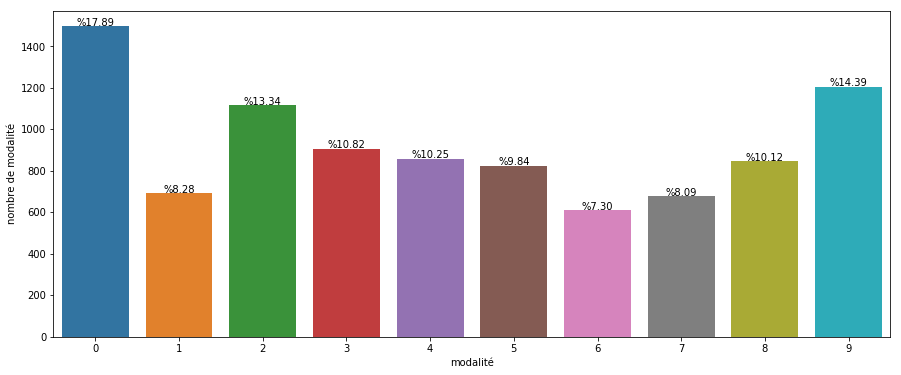

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD32
Distribution For Yes :


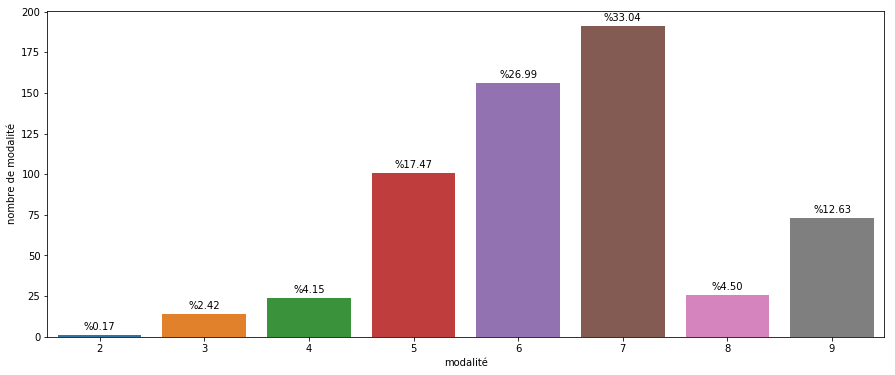

Distribution For No :


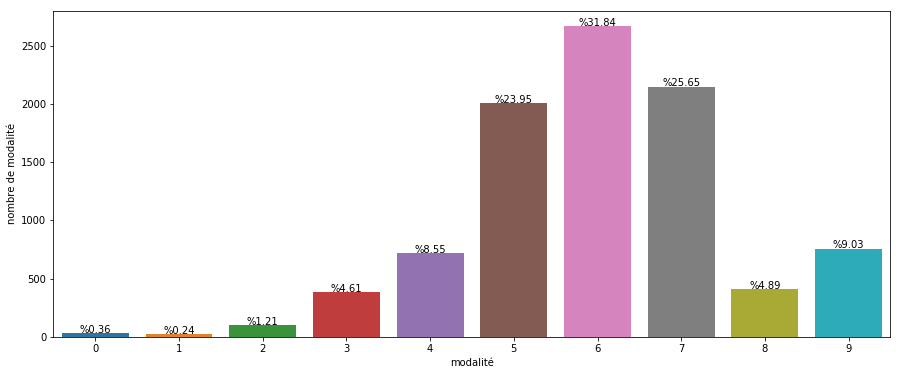

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD33
Distribution For Yes :


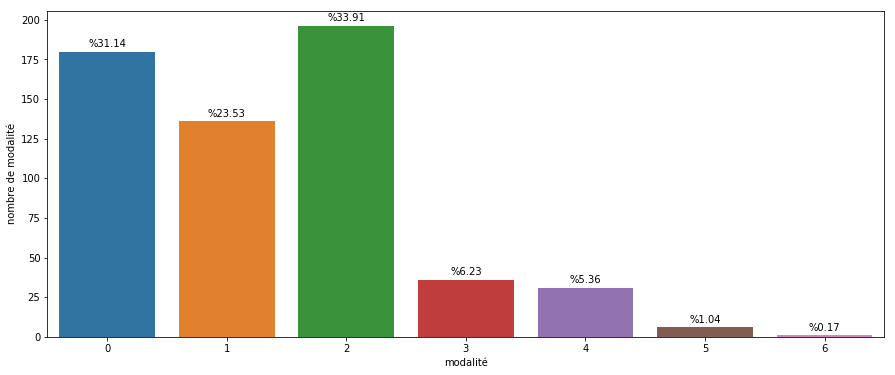

Distribution For No :


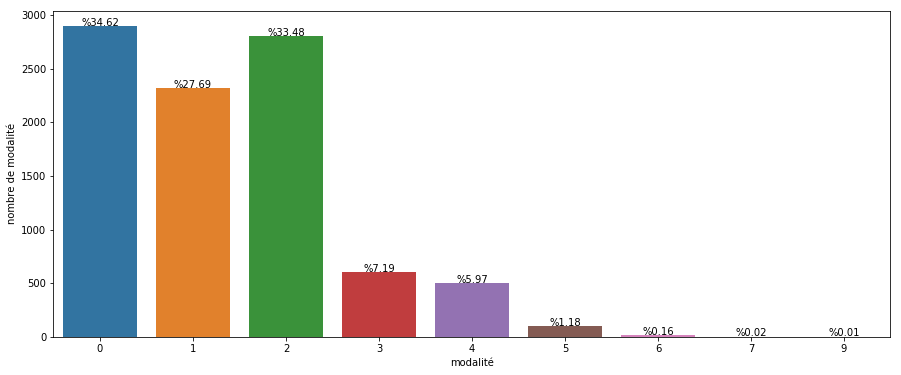

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD34
Distribution For Yes :


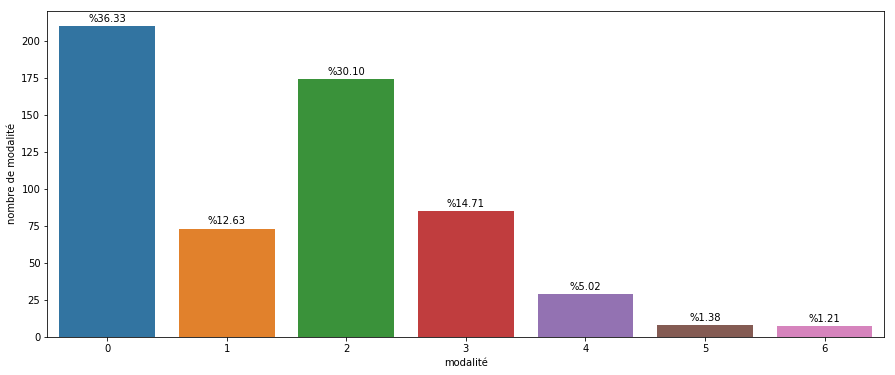

Distribution For No :


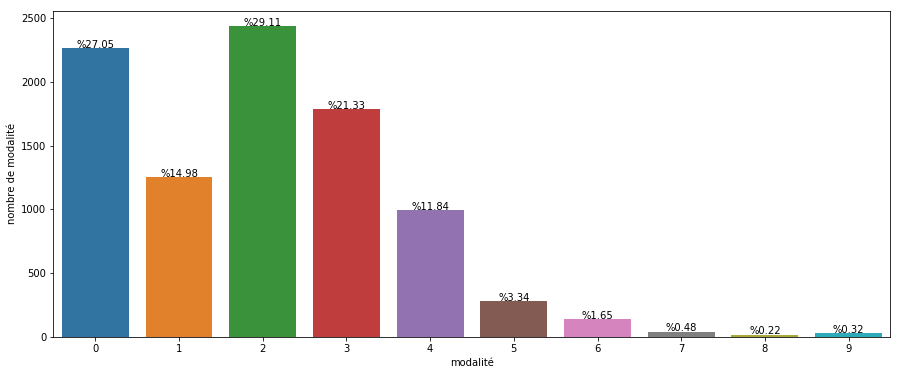

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD35
Distribution For Yes :


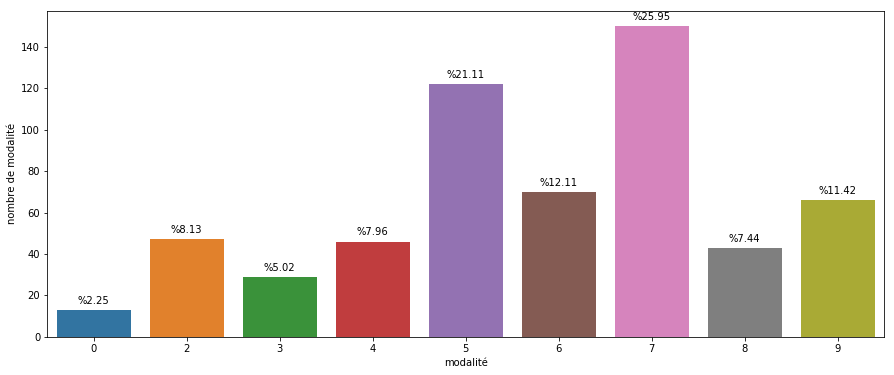

Distribution For No :


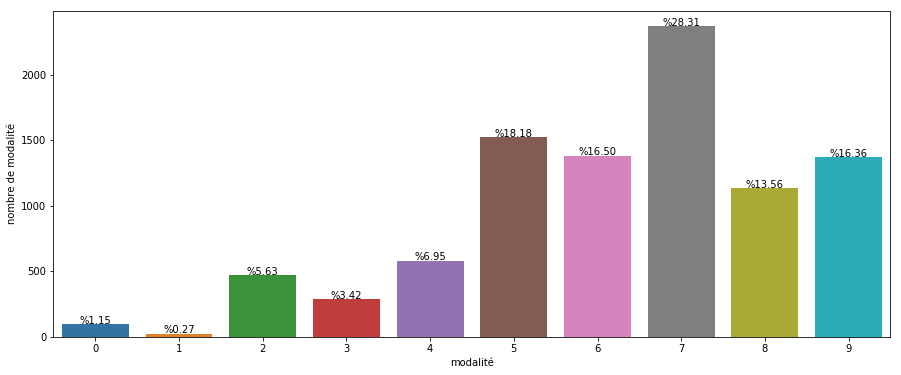

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD37
Distribution For Yes :


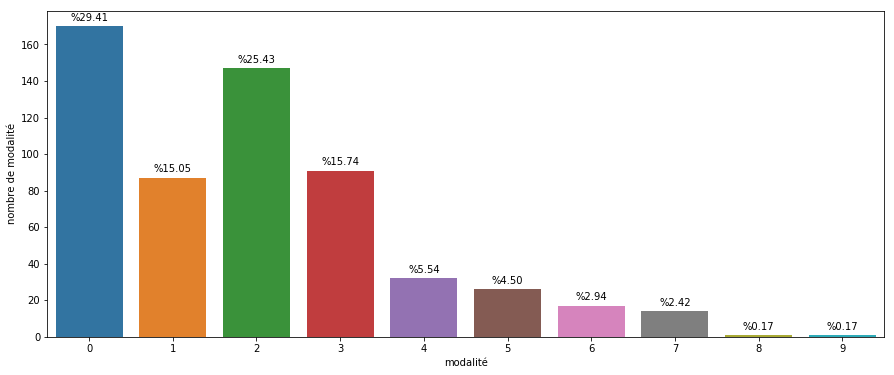

Distribution For No :


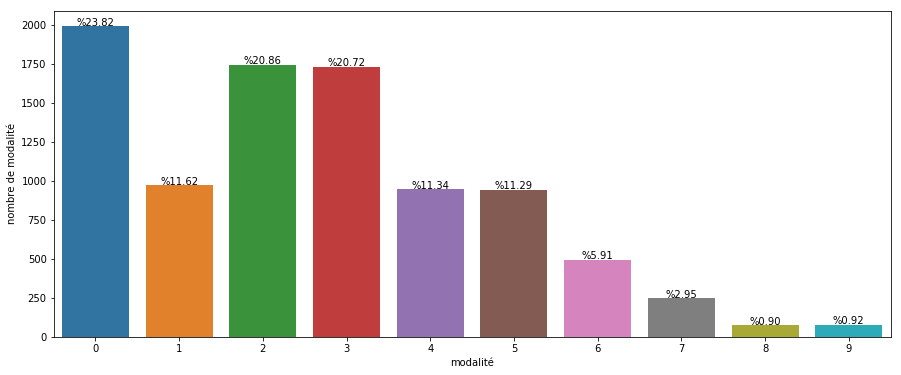

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD38
Distribution For Yes :


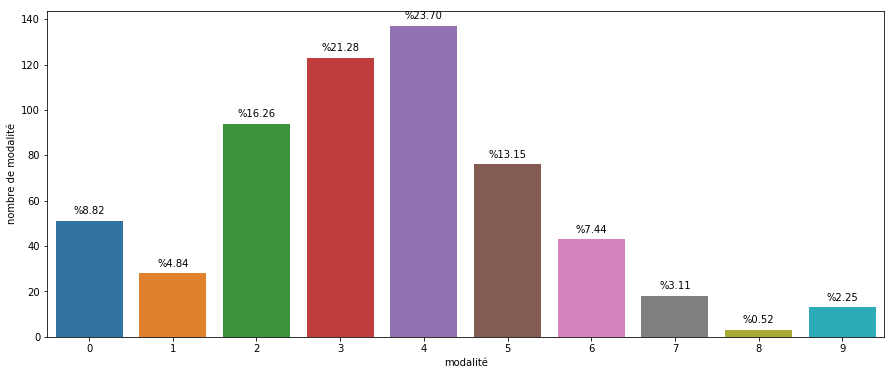

Distribution For No :


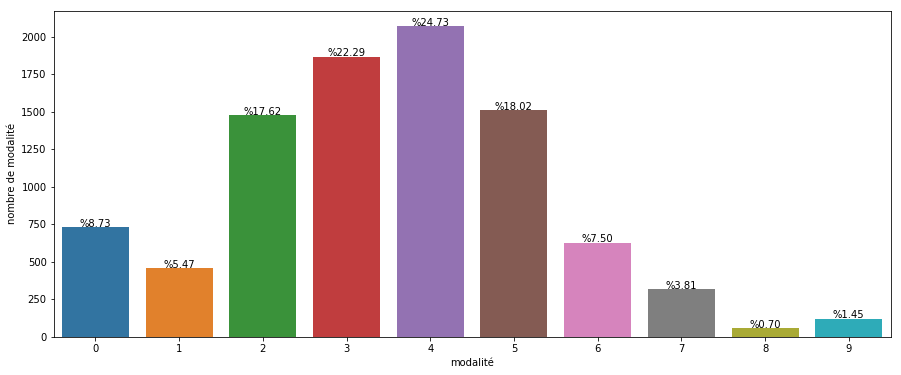

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD39
Distribution For Yes :


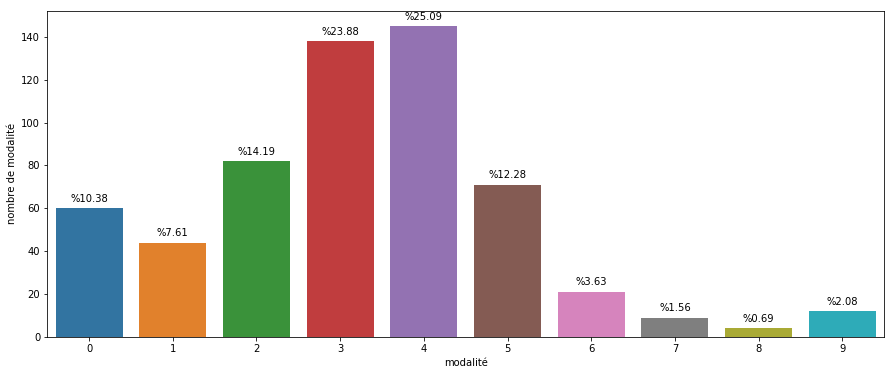

Distribution For No :


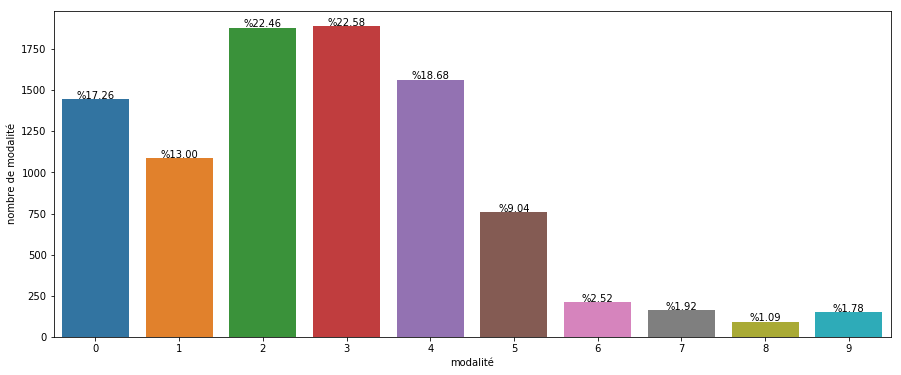

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD40
Distribution For Yes :


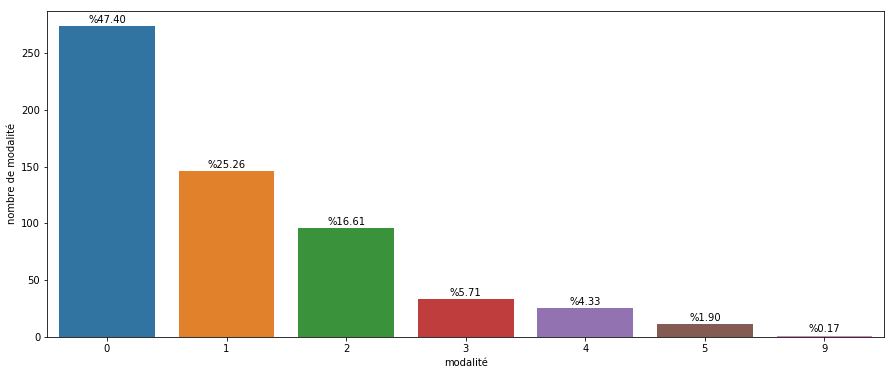

Distribution For No :


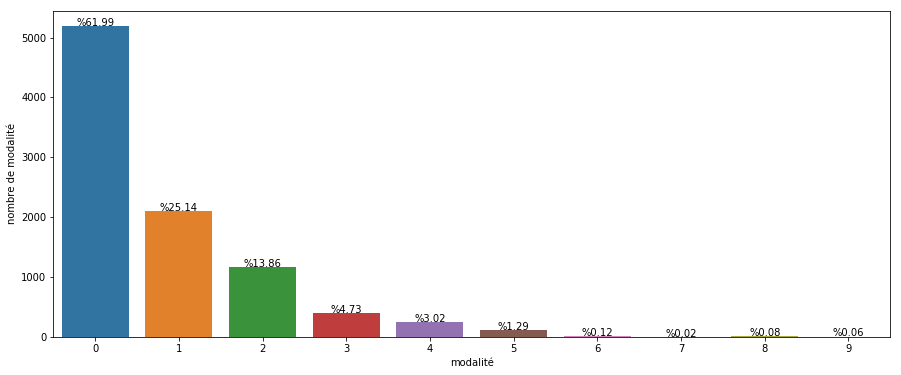

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD41
Distribution For Yes :


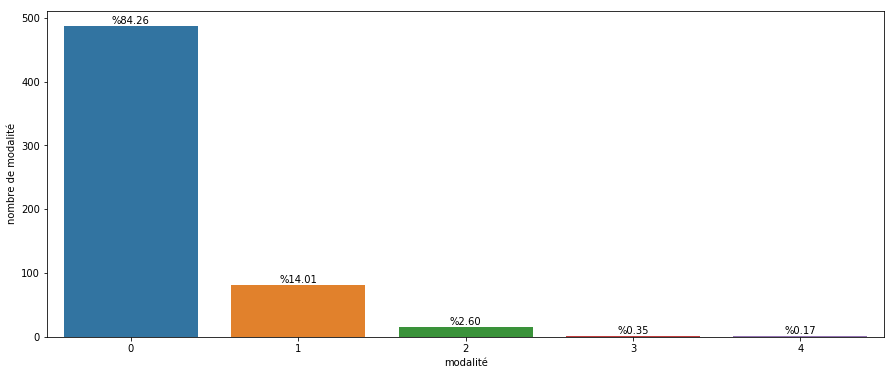

Distribution For No :


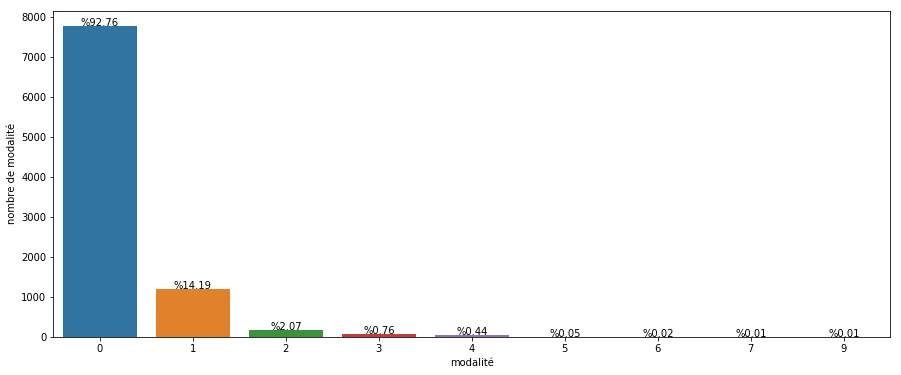

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD42
Distribution For Yes :


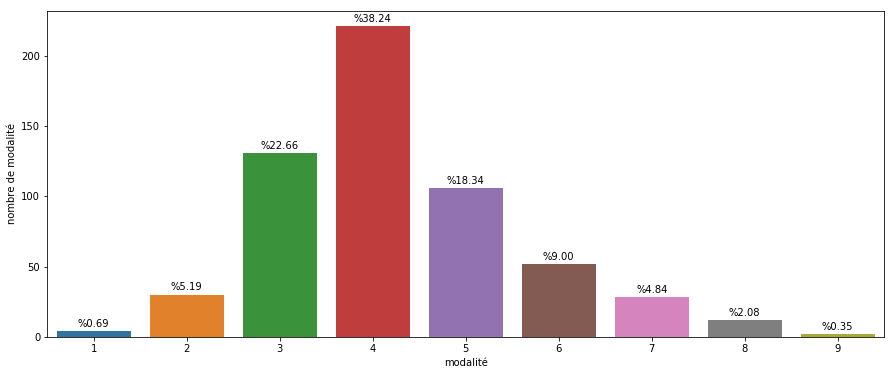

Distribution For No :


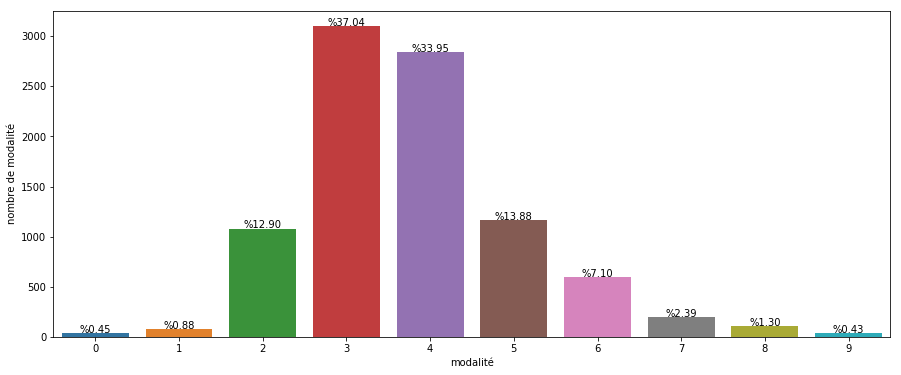

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
Distribution For Feature :  SD43
Distribution For Yes :


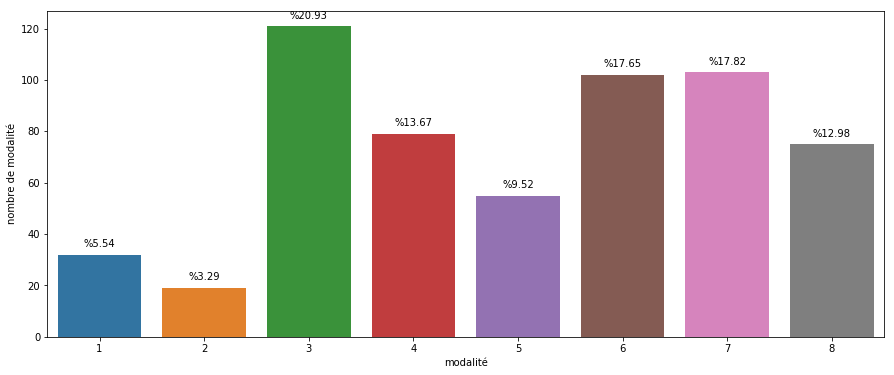

Distribution For No :


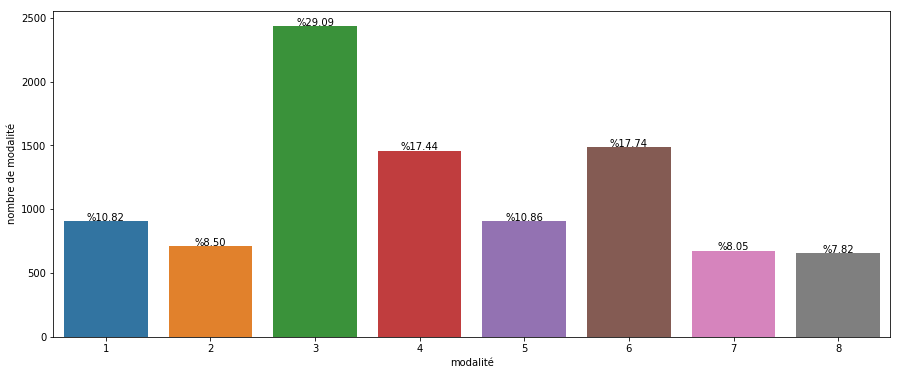

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------


In [54]:
for c in sociodémographiques :
    print("Distribution For Feature : ",c)
    print("Distribution For Yes :")
    Data_Distribution(c,tableModaliteYes,578)
    print("Distribution For No :")
    Data_Distribution(c,tableModaliteNo,8372)
    print("------------------------------------------------------------------------------------------------------------------")
    print("------------------------------------------------------------------------------------------------------------------")

### Interprétation des Données : 

d'aprés l'analyse de données on peut constater que la majorité des clients potentiellement intéréssé par une assurance sur caravane sont de la classe moyenne ou inférieure, de famille nombreuse et agé entre 30 et 60 ans .

## Donnée concernant les produits achetés : 

In [65]:
produits=dataset.columns[39:-2]

In [66]:
tableModaliteYes={}
listeModalitesYes = []
for c in produits : 
    tableModaliteYes[c]=collections.Counter(Yes[c].values)
    
tableModaliteNo={}
listeModalitesNo = []
for c in produits : 
    tableModaliteNo[c]=collections.Counter(No[c].values)

Distribution du Feature :  PO44
Distribution For Yes :


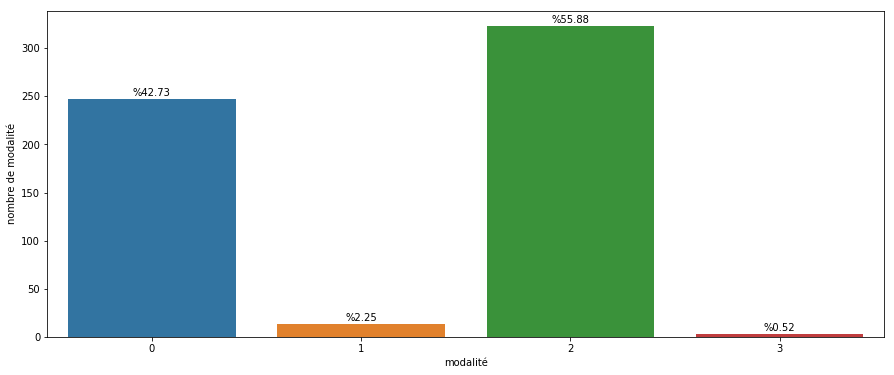

Distribution For No :


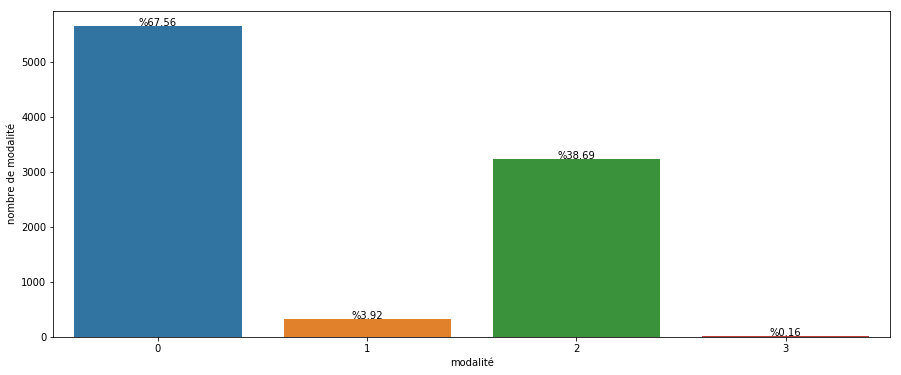

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO45
Distribution For Yes :


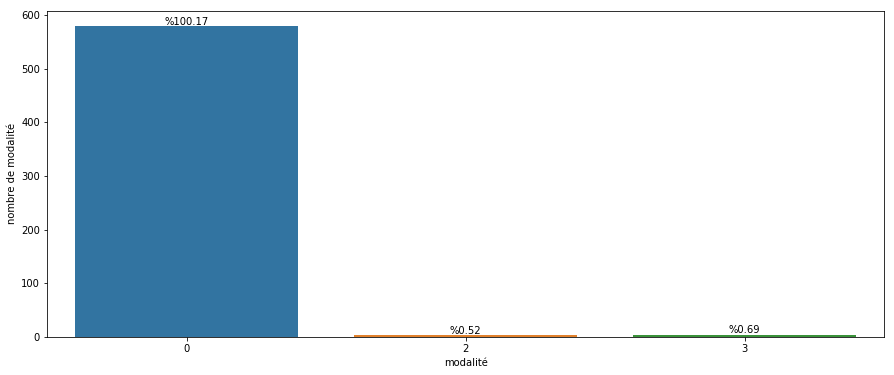

Distribution For No :


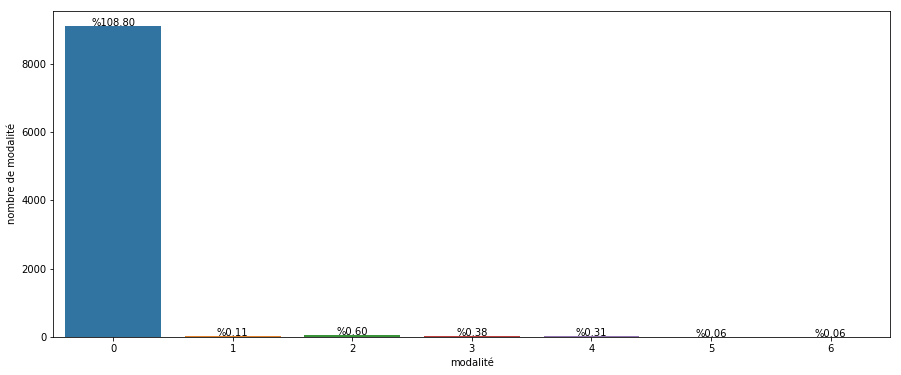

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO47
Distribution For Yes :


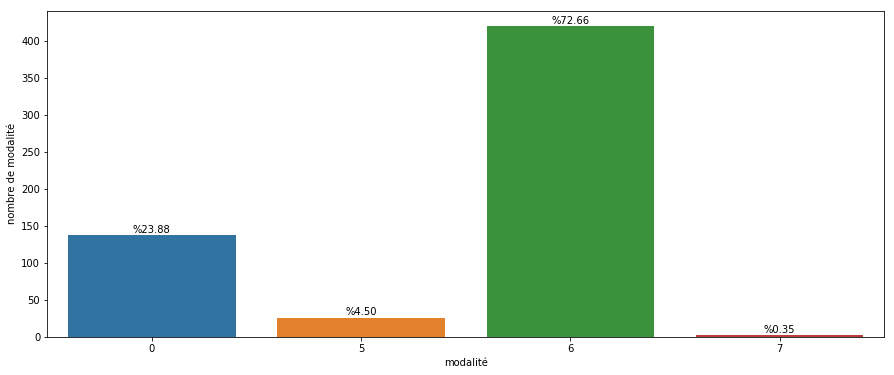

Distribution For No :


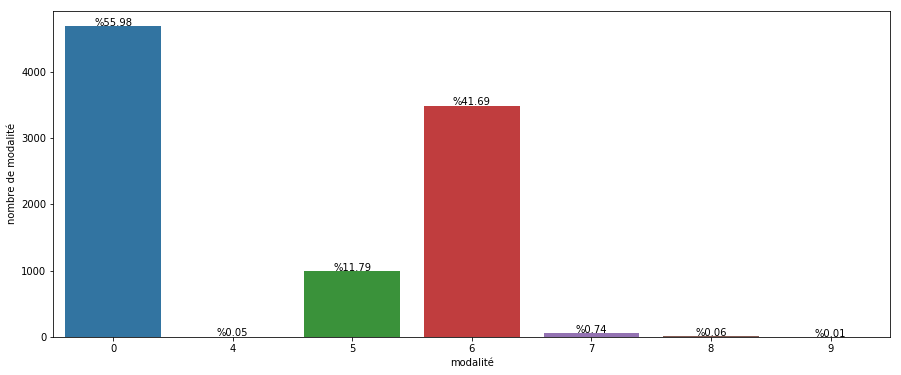

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO51
Distribution For Yes :


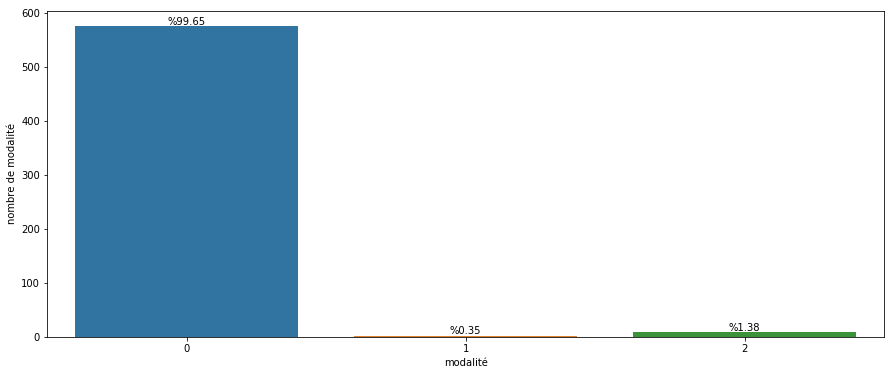

Distribution For No :


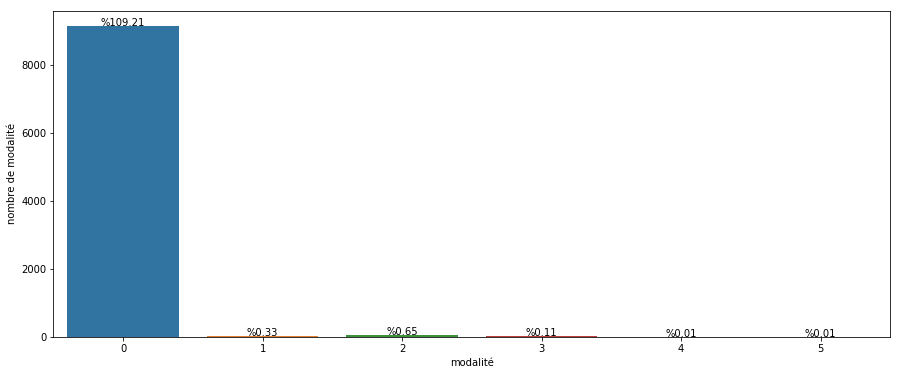

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO54
Distribution For Yes :


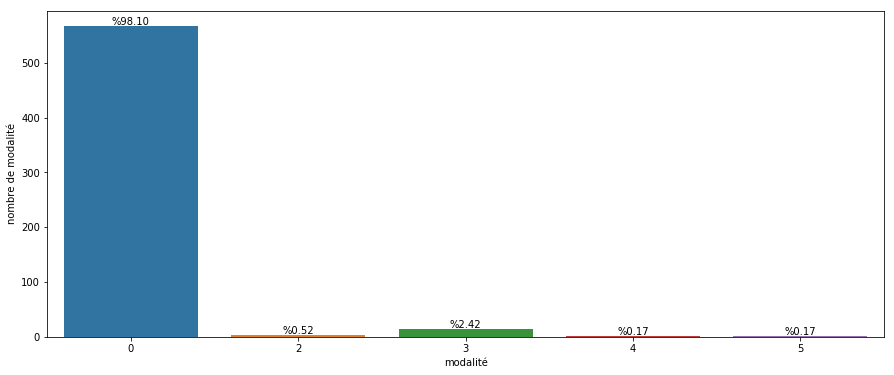

Distribution For No :


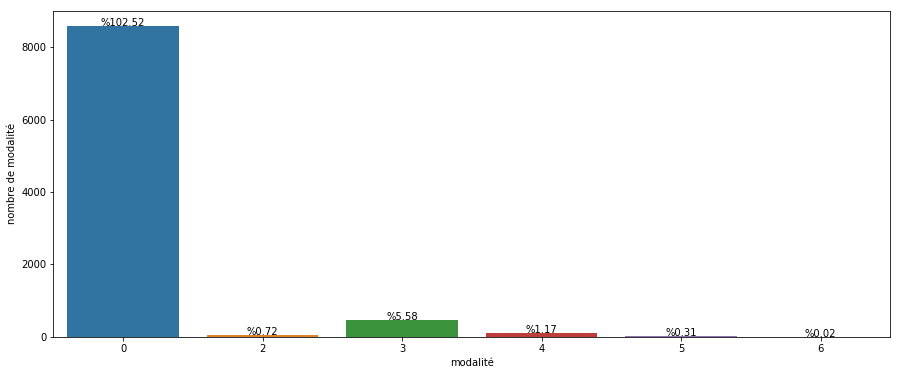

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO57
Distribution For Yes :


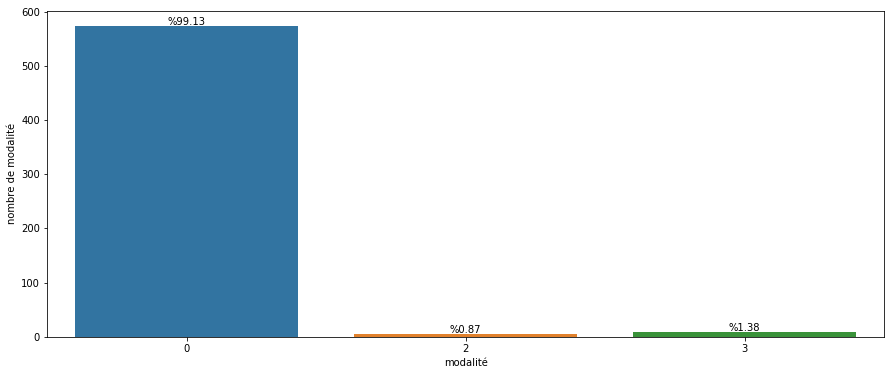

Distribution For No :


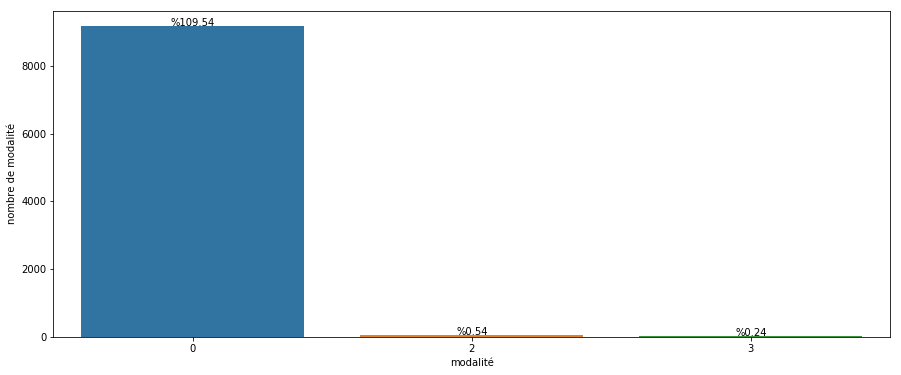

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO58
Distribution For Yes :


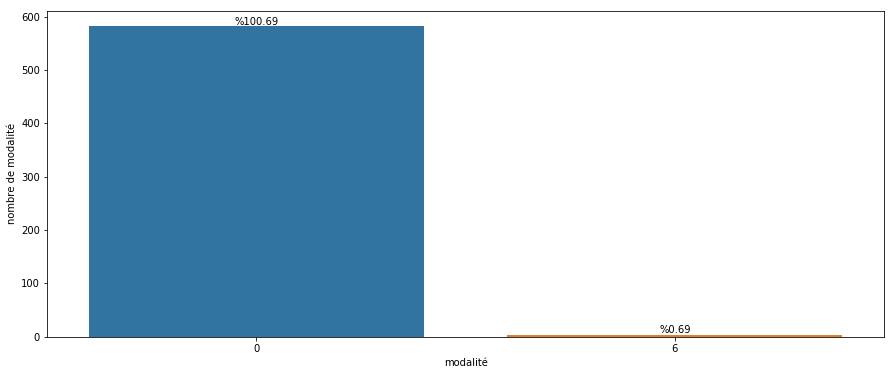

Distribution For No :


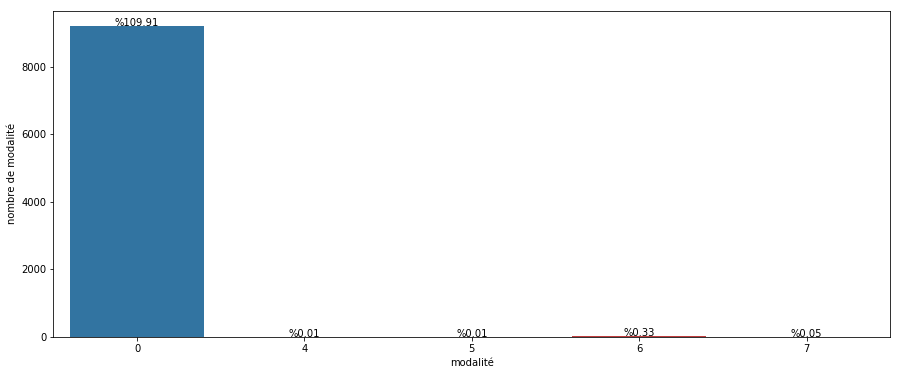

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO59
Distribution For Yes :


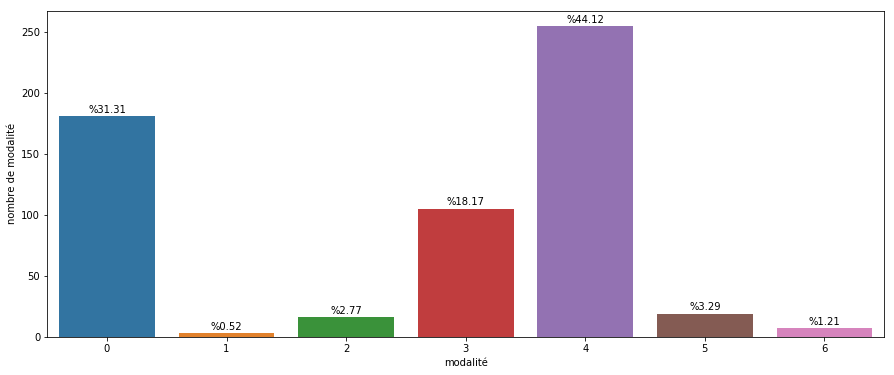

Distribution For No :


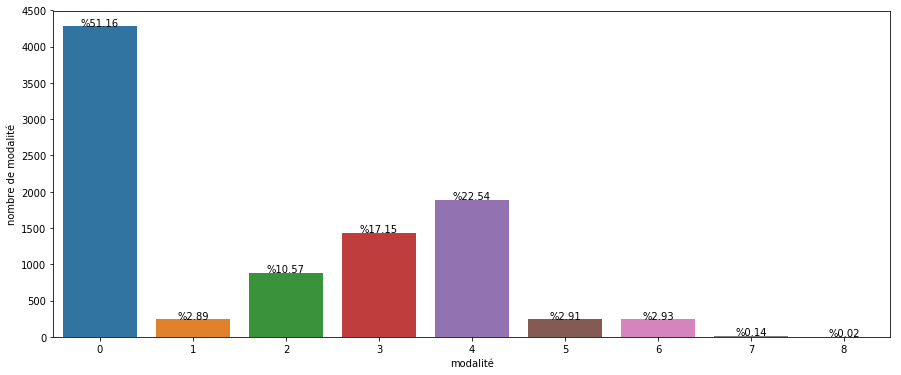

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO64
Distribution For Yes :


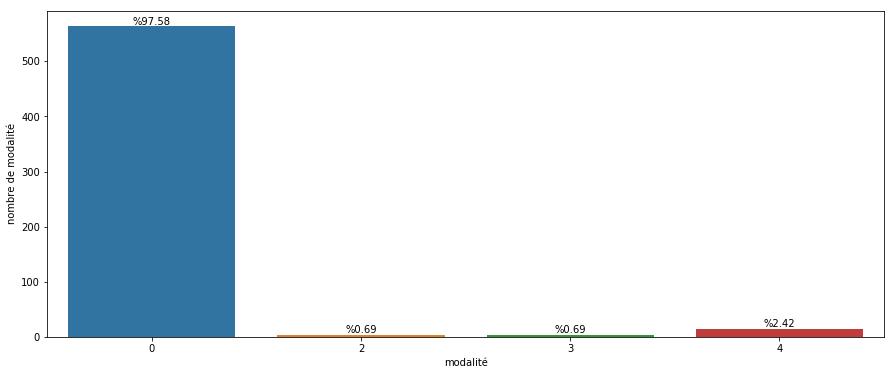

Distribution For No :


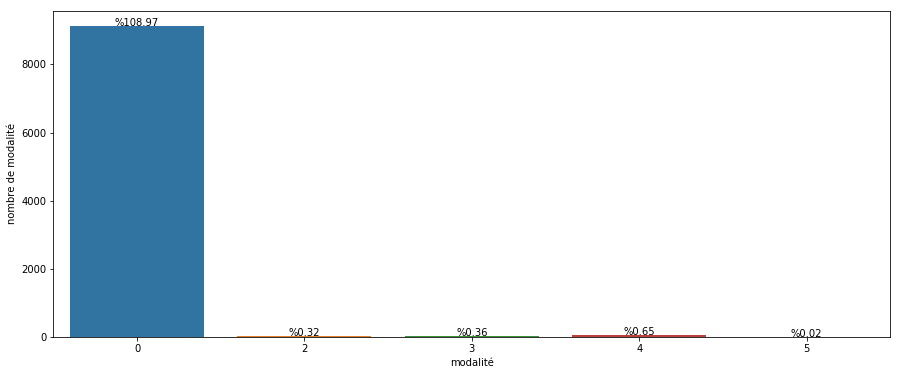

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO69
Distribution For Yes :


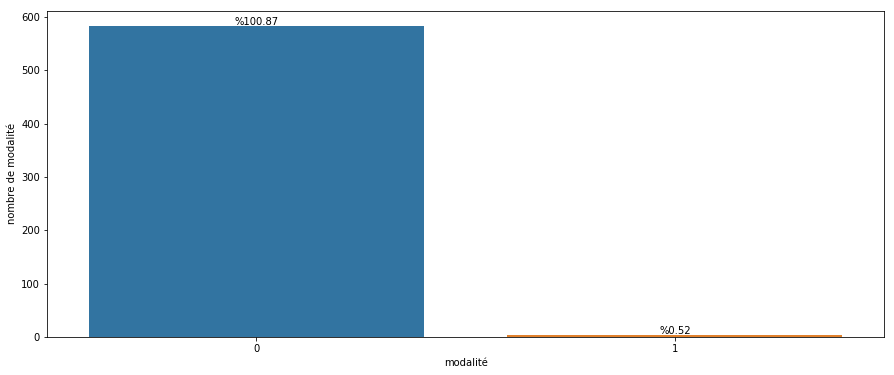

Distribution For No :


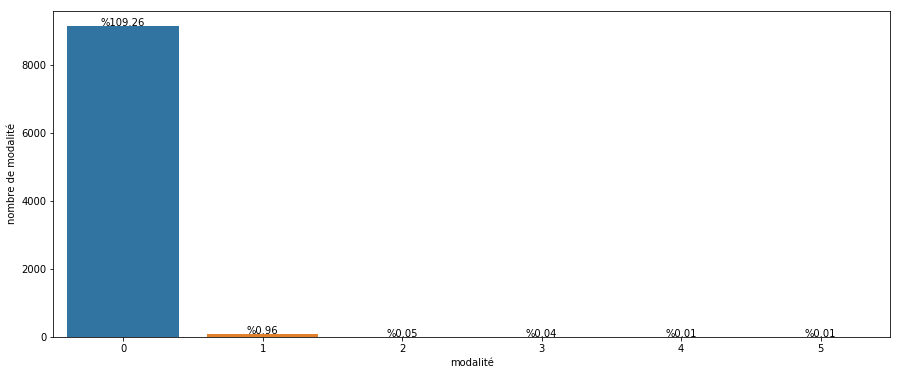

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO70
Distribution For Yes :


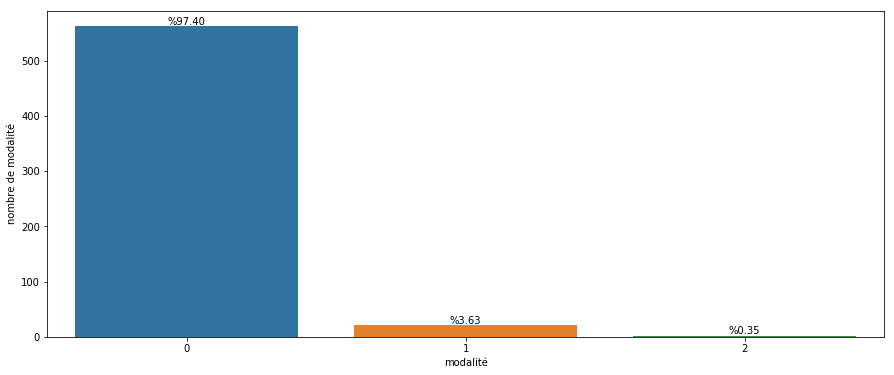

Distribution For No :


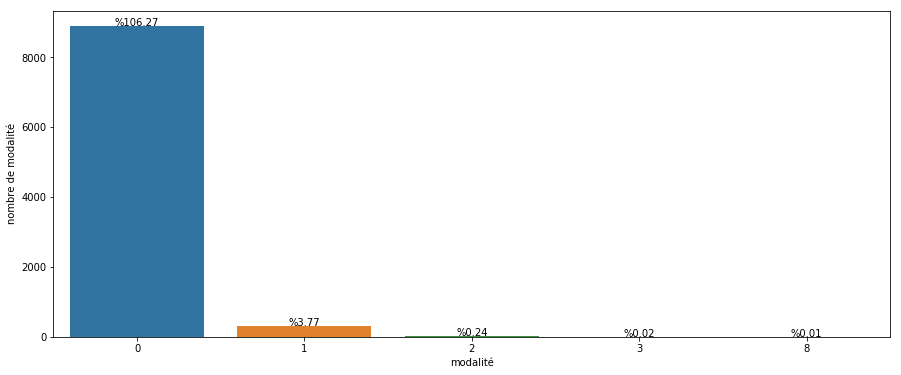

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO73
Distribution For Yes :


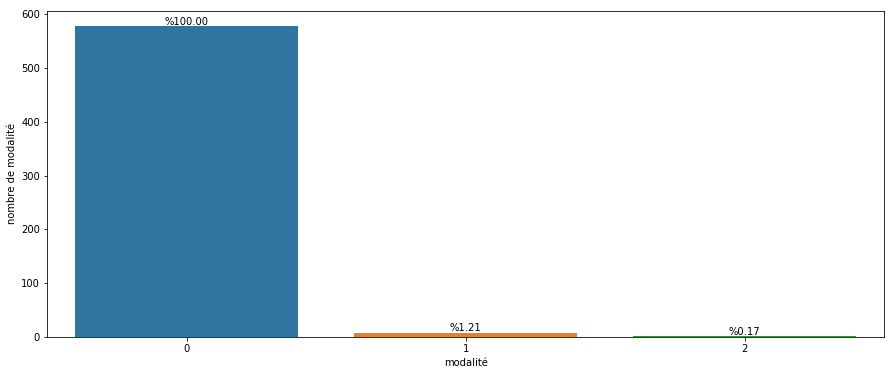

Distribution For No :


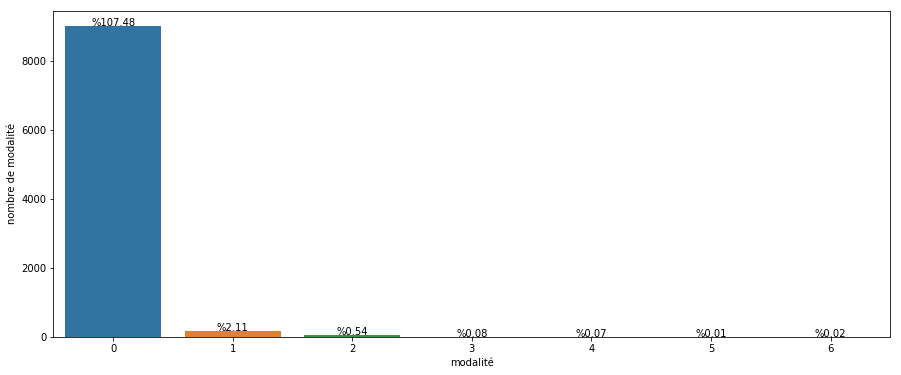

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO76
Distribution For Yes :


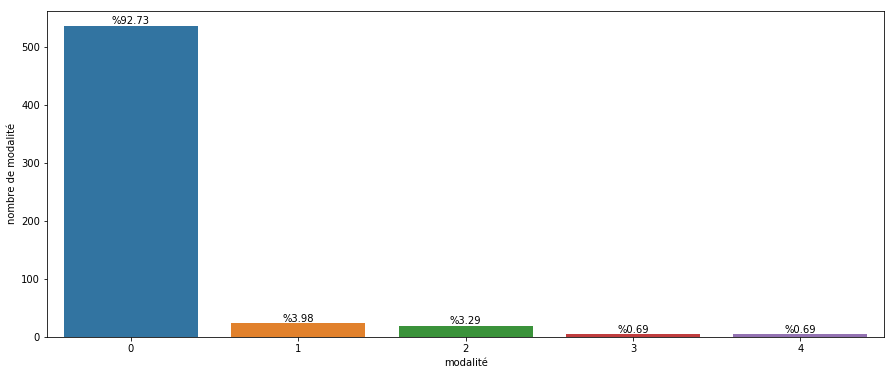

Distribution For No :


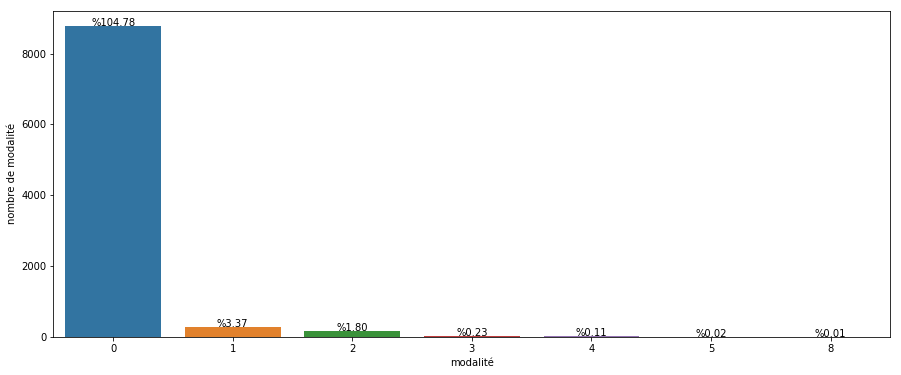

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------
Distribution du Feature :  PO82
Distribution For Yes :


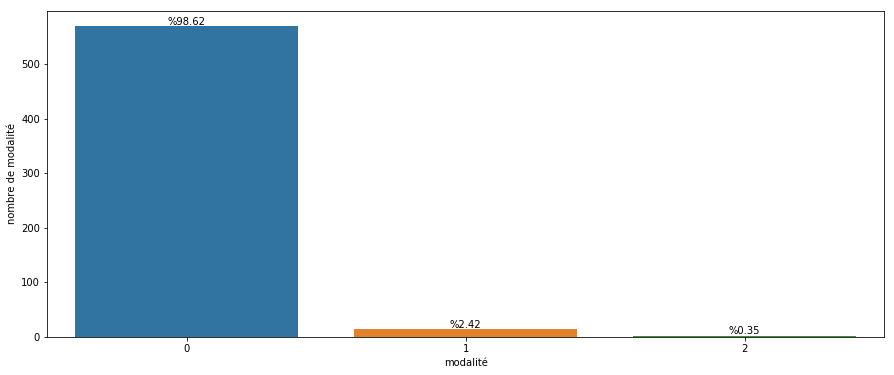

Distribution For No :


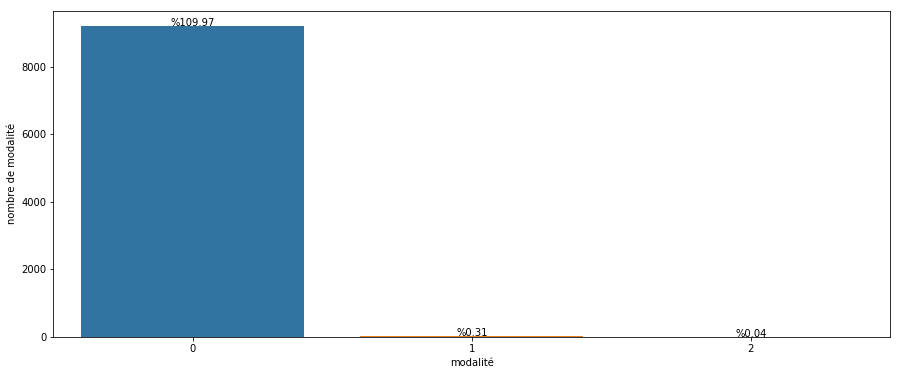

---------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------


In [67]:
for c in produits :
    if(c=='PO44' or c=='PO45' or c=='PO47' or c=='PO51' or c=='PO54' or c=='PO57' or c=='PO58' or c=='PO59' or c=='PO64' or c=='PO69' or c=='PO70' or c=='PO73' or c=='PO76' or c=='PO82'):
        print("Distribution du Feature : ",c)
        print("Distribution For Yes :")
        Data_Distribution(c,tableModaliteYes,578)
        print("Distribution For No :")
        Data_Distribution(c,tableModaliteNo,8372)
        print('---------------------------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------------------------')

### Interprétation des Données : 

les clients intéréssé par une assurance sur caravane se dinstinguent principalement par leurs contribution dans les assurances voitures .

# Scoring :

Dans cette partie, on va utiliser Stratified KFOLDS et random forest pour attribuer un score au client potentiels

In [20]:
#Stratified Kfold
def stratified_kfolds(dataset, classifier, k):
    ans = 0
    #containing validation auc best scores for each fold
    valid_score = []
    #containing training auc best scores for each fold
    train_score = []
    n = dataset.shape[0]
    kf = StratifiedKFold(n_splits=k, random_state=None)
    
    #split dataset to data(X) and labels(Y)
    X_dataset = dataset.loc[:, dataset.columns.values != "CLASS"]
    y_dataset = dataset.loc[:, dataset.columns.values == "CLASS"]
    for train_index, valid_index in kf.split(X_dataset, y_dataset):
        #split train and valid
        X_train, y_train = X_dataset.iloc[train_index, :], y_dataset.iloc[train_index, :] 
        X_valid, y_valid = X_dataset.iloc[valid_index, :], y_dataset.iloc[valid_index, :] 
        #fit model
        classifier.fit(X_train, y_train.values.ravel())
        
        

In [21]:
stratified_kfolds(dataset, clf_RF, 5)

In [22]:
X_dataset = dataset.loc[:, dataset.columns.values != "CLASS"]
y_dataset = dataset.loc[:, dataset.columns.values == "CLASS"]

In [23]:
preds = clf_RF.predict(X_dataset)
print('precision score: ', precision_score(preds, y_dataset), "\nRecall score: ",recall_score(preds,y_dataset) )



precision score:  0.658703071672355 
Recall score:  0.9039812646370023


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred=preds, y_true=y_dataset)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred=preds, y_true=y_dataset)

array([[9195,   41],
       [ 200,  386]], dtype=int64)

In [25]:


preds = clf_RF.predict_proba(X_dataset)

preds = preds[:, 1]

dataset["Score"] = preds
dataset.head(100)

,SD1,SD2,SD3,SD4,SD6,SD7,SD8,SD9,SD10,SD11,...,PO64,PO69,PO70,PO73,PO76,PO82,PO83,PO84,CLASS,Score
0,33,1,3,2,0,5,1,3,7,0,...,0,0,0,0,0,0,0,0,0,0.010000
1,37,1,2,2,1,4,1,4,6,2,...,0,0,0,0,0,0,0,0,0,0.020000
2,37,1,2,2,0,4,2,4,3,2,...,0,0,0,0,0,0,0,0,0,0.000000
3,9,1,3,3,2,3,2,4,5,2,...,0,0,0,0,0,0,0,0,0,0.010000
4,40,1,4,2,1,4,1,4,7,1,...,0,0,0,0,0,0,0,0,0,0.000000
5,23,1,2,1,0,5,0,5,0,6,...,0,0,0,0,0,0,0,0,0,0.000000
6,39,2,3,2,2,2,0,5,7,2,...,0,0,0,0,0,0,0,0,0,0.000000
7,33,1,2,3,0,7,0,2,7,2,...,0,0,0,0,0,0,0,0,0,0.009524
8,33,1,2,4,0,1,3,6,6,0,...,0,0,0,0,0,0,0,0,0,0.453750
9,11,2,3,3,3,5,0,2,7,0,...,0,0,0,0,0,0,0,0,0,0.014000


On range notre dataset selon un ordre décroissant des scores obtenus

In [26]:
dataset_sorted = dataset.sort_values(by='Score', ascending = False)
dataset_sorted.head(100)

,SD1,SD2,SD3,SD4,SD6,SD7,SD8,SD9,SD10,SD11,...,PO64,PO69,PO70,PO73,PO76,PO82,PO83,PO84,CLASS,Score
2014,9,1,3,3,1,4,1,5,7,1,...,0,0,0,0,0,0,0,0,1,0.930000
5175,9,1,3,3,1,4,1,5,7,1,...,0,0,0,0,0,0,0,0,1,0.930000
6053,9,1,3,3,1,4,1,5,7,1,...,0,0,0,0,0,0,0,0,1,0.930000
3741,12,2,4,2,2,4,2,2,9,0,...,0,0,0,0,0,0,0,0,1,0.922500
5170,12,2,4,2,2,4,2,2,9,0,...,0,0,0,0,0,0,0,0,1,0.922500
4881,12,2,4,2,2,4,2,2,9,0,...,4,0,0,0,0,0,0,0,1,0.920000
1891,8,1,4,3,1,5,1,3,7,1,...,0,0,0,0,0,0,0,0,1,0.913333
7155,8,1,4,3,1,5,1,3,7,1,...,0,0,0,0,0,0,0,0,1,0.913333
1319,12,2,4,2,0,2,0,7,9,0,...,0,0,0,0,0,0,0,0,1,0.890000
834,12,2,4,2,0,2,0,7,9,0,...,0,0,0,0,0,0,0,0,1,0.890000


On détermine ici la liste des clients cibles qui sont plus susceptibles d'acheter la police d'assurance selon le score obtenu par le modele.

In [27]:
client_cible = dataset_sorted.iloc[:dataset.shape[0]//2,: ]
client_cible.head(500)


,SD1,SD2,SD3,SD4,SD6,SD7,SD8,SD9,SD10,SD11,...,PO64,PO69,PO70,PO73,PO76,PO82,PO83,PO84,CLASS,Score
2014,9,1,3,3,1,4,1,5,7,1,...,0,0,0,0,0,0,0,0,1,0.930000
5175,9,1,3,3,1,4,1,5,7,1,...,0,0,0,0,0,0,0,0,1,0.930000
6053,9,1,3,3,1,4,1,5,7,1,...,0,0,0,0,0,0,0,0,1,0.930000
3741,12,2,4,2,2,4,2,2,9,0,...,0,0,0,0,0,0,0,0,1,0.922500
5170,12,2,4,2,2,4,2,2,9,0,...,0,0,0,0,0,0,0,0,1,0.922500
4881,12,2,4,2,2,4,2,2,9,0,...,4,0,0,0,0,0,0,0,1,0.920000
1891,8,1,4,3,1,5,1,3,7,1,...,0,0,0,0,0,0,0,0,1,0.913333
7155,8,1,4,3,1,5,1,3,7,1,...,0,0,0,0,0,0,0,0,1,0.913333
1319,12,2,4,2,0,2,0,7,9,0,...,0,0,0,0,0,0,0,0,1,0.890000
834,12,2,4,2,0,2,0,7,9,0,...,0,0,0,0,0,0,0,0,1,0.890000
